### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [13]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

#import statmorph
import time



import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

In [14]:
## Runtime config.

fields = ['gini', 'm20']#, 'concentration', 'asymmetry', 'smoothness']

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [15]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [16]:
from astrobf.utils.misc import load_Nair
cat = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')

good_gids = np.array([gal['img_name'] for gal in all_gals])
inds = cat['ID'].searchsorted(good_gids)
cat = cat[inds]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

### Clustering performance metric

cluster member의 T type의 Homogeniety를 고려하는 metric이 필요함. 
Scikit-learn의 clutering metric을 테스트해 본 결과 경향은 대동소이하며, Silhouette_score만 가끔씩 튐. 

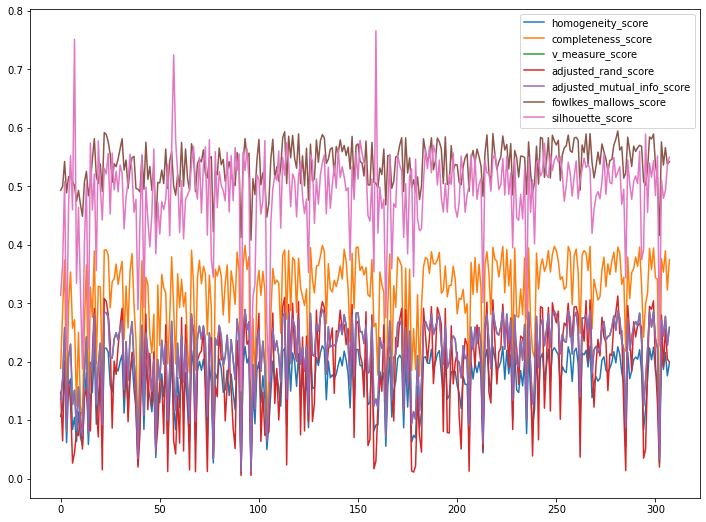

Homogeneity / completeness / v_measure는 비슷하며, v_measure는 앞 두개의 조합임. 



In [41]:
from astrobf.morph import custom_morph
labeler2 = lambda results : np.array((results['ttype'] >= 1) * (results['ttype'] < 6), dtype=int)

def labeler4(results):
    labels = np.zeros(len(results), dtype=int)
    labels[results['ttype']< 0] = 0
    labels[(results['ttype'] >= 0) * (results['ttype'] < 3)] = 1
    labels[(results['ttype'] >= 3) * (results['ttype'] < 7)] = 2
    labels[results['ttype'] >= 7] = 3
    return labels

labeler = labeler2

# This part is ad-hoc... 
#assert cat['ID'] == good_gids  # In different format U20 vs U24.
cat_label = np.array((cat['TT'] >= 1) * (cat['TT'] < 6), dtype=int)
ind1 = np.where(cat_label == 0)[0]
ind2 = np.where(cat_label == 1)[0]

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    params1 = {'b':params['b'], 'c':params['c'], 'dl':params['dl'],'dh':params['dh']}
    params2 = {'b':params['b2'], 'c':params['c2'], 'dl':params['dl2'],'dh':params['dh2']}
    
    result_arr1 = custom_morph.step_simple_morph(all_gals, params1, ind1)
    if result_arr1[0] == "bad":
        return {"mymetric": (-1, 0), "total_flux":(result_arr1[1],0)}
    result_arr2 = custom_morph.step_simple_morph(all_gals, params2, ind2)
    if result_arr2[0] == "bad":
        return {"mymetric": (-1, 0), "total_flux":(result_arr2[1],0)}

    # sort
    result_arr = np.concatenate((result_arr1, result_arr2))
    inds = result_arr['id'].searchsorted(good_gids)
    result_arr = result_arr[inds]    
    
    Full_exp.add_ttype(result_arr, cat)
    eval_metrics = Full_exp.do_ML(result_arr, labeler, cat, n_clusters=2,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

In [49]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'

for fn_result, cluster_method in zip(["FMS_2G_2p_spec", "FMS_2G_2p_agg", "FMS_2G_2p_ward"],
                                     ['spectral', 'agglomerate', 'ward']):

    axc = AxClient()

    axc.create_experiment(
        parameters=[
            {"name": "b",
            "type": "range",
            "bounds": [1.0, 4.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False},
            {"name": "b2",
            "type": "range",
            "bounds": [1.0, 4.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False},
            {"name": "c",
            "type": "range",
            "bounds": [0.5, 5.0]},
            {"name": "c2",
            "type": "range",
            "bounds": [0.5, 5.0]},
            {"name": "dl",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dl2",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dh",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dh2",
            "type": "range",
            "bounds": [0.5, 8.0]},
        ],
        objective_name="mymetric",
        #minimize=True,  # Optional, defaults to False. Maximize Shiloutte score
        parameter_constraints=["b - dl <= 100"], # all images are stretched to 100
        overwrite_existing_experiment =True,
        outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

    all_metrics=[]
    for i in range(500):
        parameters, trial_index = axc.get_next_trial()
        axc.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters, cluster_method=cluster_method))
        if i % 50 == 49:
            print(f"{i}-th done")

    pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

    if True:
        axc.save_to_json_file(exp_dir+fn_result+".json")
    else:
        axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 05-17 07:23:04] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 05-17 07:23:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-17 07:23:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-17 07:23:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dl. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-17 07:23:04] ax.service.util

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:23:26] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:23:26] ax.service.ax_client: Generated new trial 1 with parameters {'b': 1.23, 'b2': 2.92, 'c': 3.77, 'c2': 4.6, 'dl': 7.76, 'dl2': 7.37, 'dh': 2.18, 'dh2': 3.92}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:23:52] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:23:52] ax.service.ax_client: Generated new trial 2 with parameters {'b': 1.5, 'b2': 1.19, 'c': 0.52, 'c2': 3.09, 'dl': 1.32, 'dl2': 4.7, 'dh': 6.27, 'dh2': 7.96}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:24:16] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:24:16] ax.service.ax_client: Generated new trial 3 with parameters {'b': 3.45, 'b2': 3.75, 'c': 1.1, 'c2': 1.38, 'dl': 7.68, 'dl2': 5.06, 'dh': 1.59, 'dh2': 4.86}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:24:41] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:24:41] ax.service.ax_client: Generated new trial 4 with parameters {'b': 2.84, 'b2': 3.51, 'c': 3.93, 'c2': 0.6, 'dl': 1.18, 'dl2': 3.44, 'dh': 1.32, 'dh2': 3.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:25:01] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:25:01] ax.service.ax_client: Generated new trial 5 with parameters {'b': 2.19, 'b2': 1.06, 'c': 1.57, 'c2': 2.02, 'dl': 5.18, 'dl2': 1.41, 'dh': 3.87, 'dh2': 5.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:25:26] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:25:26] ax.service.ax_client: Generated new trial 6 with parameters {'b': 2.48, 'b2': 2.58, 'c': 4.52, 'c2': 2.12, 'dl': 5.65, 'dl2': 4.58, 'dh': 7.66, 'dh2': 4.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:25:51] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:25:51] ax.service.ax_client: Generated new trial 7 with parameters {'b': 1.78, 'b2': 1.83, 'c': 1.89, 'c2': 3.3, 'dl': 3.35, 'dl2': 3.59, 'dh': 3.21, 'dh2': 5.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:26:16] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:26:16] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:26:18] ax.service.ax_client: Generated new trial 8 with parameters {'b': 2.17, 'b2': 2.46, 'c': 2.21, 'c2': 3.42, 'dl': 5.7, 'dl2': 0.75, 'dh': 5.8, 'dh2': 3.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:26:39] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:26:39] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:26:40] ax.service.ax_client: Generated new trial 9 with parameters {'b': 2.06, 'b2': 2.66, 'c': 2.41, 'c2': 3.72, 'dl': 5.62, 'dl2': 1.64, 'dh': 5.61, 'dh2': 3.74}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparis

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:27:02] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:27:02] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:27:04] ax.service.ax_client: Generated new trial 10 with parameters {'b': 2.26, 'b2': 2.43, 'c': 2.38, 'c2': 3.63, 'dl': 5.12, 'dl2': 1.5, 'dh': 5.73, 'dh2': 3.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:27:26] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:27:26] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:27:28] ax.service.ax_client: Generated new trial 11 with parameters {'b': 2.0, 'b2': 2.48, 'c': 2.66, 'c2': 3.51, 'dl': 5.23, 'dl2': 1.09, 'dh': 5.6, 'dh2': 3.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:27:50] ax.service.ax_client: Completed trial 11 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:27:50] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:27:51] ax.service.ax_client: Generated new trial 12 with parameters {'b': 2.26, 'b2': 2.67, 'c': 2.43, 'c2': 3.68, 'dl': 5.1, 'dl2': 1.11, 'dh': 5.42, 'dh2': 4.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:28:13] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:28:13] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:28:15] ax.service.ax_client: Generated new trial 13 with parameters {'b': 2.08, 'b2': 2.86, 'c': 2.24, 'c2': 3.43, 'dl': 4.82, 'dl2': 1.21, 'dh': 5.81, 'dh2': 3.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == compar

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:28:36] ax.service.ax_client: Completed trial 13 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:28:36] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:28:38] ax.service.ax_client: Generated new trial 14 with parameters {'b': 2.15, 'b2': 2.7, 'c': 2.41, 'c2': 3.79, 'dl': 4.99, 'dl2': 1.23, 'dh': 6.26, 'dh2': 4.25}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == compari

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:29:00] ax.service.ax_client: Completed trial 14 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:29:00] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:29:01] ax.service.ax_client: Generated new trial 15 with parameters {'b': 2.32, 'b2': 2.85, 'c': 2.52, 'c2': 3.29, 'dl': 5.46, 'dl2': 1.27, 'dh': 5.79, 'dh2': 3.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:29:24] ax.service.ax_client: Completed trial 15 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:29:24] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:29:25] ax.service.ax_client: Generated new trial 16 with parameters {'b': 2.19, 'b2': 2.79, 'c': 2.21, 'c2': 3.54, 'dl': 5.42, 'dl2': 1.24, 'dh': 5.59, 'dh2': 3.7}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == compari

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:29:47] ax.service.ax_client: Completed trial 16 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:29:47] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:29:49] ax.service.ax_client: Generated new trial 17 with parameters {'b': 2.22, 'b2': 2.78, 'c': 2.42, 'c2': 3.45, 'dl': 5.05, 'dl2': 1.27, 'dh': 5.6, 'dh2': 3.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == compari

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:30:11] ax.service.ax_client: Completed trial 17 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:30:11] ax.modelbridge.transforms.standardize_y: Outcome total_flux is constant, within tolerance.
[INFO 05-17 07:30:12] ax.service.ax_client: Generated new trial 18 with parameters {'b': 2.11, 'b2': 3.28, 'c': 2.3, 'c2': 3.56, 'dl': 5.33, 'dl2': 0.9, 'dh': 6.05, 'dh2': 3.58}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-17 07:30:22] ax.service.ax_client: Completed trial 18 with data: {

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:30:46] ax.service.ax_client: Completed trial 19 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:30:47] ax.service.ax_client: Generated new trial 20 with parameters {'b': 2.69, 'b2': 2.51, 'c': 2.85, 'c2': 4.58, 'dl': 6.16, 'dl2': 2.56, 'dh': 4.61, 'dh2': 5.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:31:10] ax.service.ax_client: Completed trial 20 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:31:11] ax.service.ax_client: Generated new trial 21 with parameters {'b': 1.74, 'b2': 2.53, 'c': 0.87, 'c2': 4.11, 'dl': 3.01, 'dl2': 1.61, 'dh': 4.87, 'dh2': 4.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:31:33] ax.service.ax_client: Completed trial 21 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:31:34] ax.service.ax_client: Generated new trial 22 with parameters {'b': 2.77, 'b2': 2.48, 'c': 2.05, 'c2': 3.15, 'dl': 1.65, 'dl2': 1.43, 'dh': 6.06, 'dh2': 5.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:31:53] ax.service.ax_client: Completed trial 22 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:31:54] ax.service.ax_client: Generated new trial 23 with parameters {'b': 2.56, 'b2': 2.5, 'c': 1.46, 'c2': 2.58, 'dl': 3.49, 'dl2': 3.11, 'dh': 3.57, 'dh2': 3.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:32:19] ax.service.ax_client: Completed trial 23 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:32:20] ax.service.ax_client: Generated new trial 24 with parameters {'b': 1.93, 'b2': 2.47, 'c': 1.39, 'c2': 3.48, 'dl': 3.3, 'dl2': 3.89, 'dh': 7.53, 'dh2': 4.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:32:45] ax.service.ax_client: Completed trial 24 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:32:46] ax.service.ax_client: Generated new trial 25 with parameters {'b': 2.35, 'b2': 2.38, 'c': 2.28, 'c2': 4.06, 'dl': 1.73, 'dl2': 0.5, 'dh': 3.2, 'dh2': 4.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-17 07:32:53] ax.service.ax_client: Completed trial 25 with data: {'mymetric': (-1, 0), 'total_flux': (-98.0, 0)}.


[m20] Negative second moment(s).


[INFO 05-17 07:32:55] ax.service.ax_client: Generated new trial 26 with parameters {'b': 2.11, 'b2': 2.57, 'c': 0.87, 'c2': 3.19, 'dl': 3.84, 'dl2': 2.67, 'dh': 5.35, 'dh2': 4.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:33:19] ax.service.ax_client: Completed trial 26 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:33:21] ax.service.ax_client: Generated new trial 27 with parameters {'b': 2.42, 'b2': 2.58, 'c': 1.72, 'c2': 2.13, 'dl': 5.08, 'dl2': 4.39, 'dh': 3.61, 'dh2': 4.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:33:47] ax.service.ax_client: Completed trial 27 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:33:49] ax.service.ax_client: Generated new trial 28 with parameters {'b': 1.52, 'b2': 2.55, 'c': 0.96, 'c2': 4.27, 'dl': 3.42, 'dl2': 1.36, 'dh': 6.12, 'dh2': 4.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:34:11] ax.service.ax_client: Completed trial 28 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:34:13] ax.service.ax_client: Generated new trial 29 with parameters {'b': 2.59, 'b2': 2.48, 'c': 2.6, 'c2': 2.73, 'dl': 3.39, 'dl2': 1.9, 'dh': 6.76, 'dh2': 4.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:34:36] ax.service.ax_client: Completed trial 29 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:34:38] ax.service.ax_client: Generated new trial 30 with parameters {'b': 1.87, 'b2': 1.42, 'c': 1.35, 'c2': 2.69, 'dl': 4.12, 'dl2': 3.2, 'dh': 4.06, 'dh2': 6.05}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:35:03] ax.service.ax_client: Completed trial 30 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:35:06] ax.service.ax_client: Generated new trial 31 with parameters {'b': 2.69, 'b2': 2.44, 'c': 2.05, 'c2': 4.44, 'dl': 3.83, 'dl2': 2.18, 'dh': 6.47, 'dh2': 6.09}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:35:29] ax.service.ax_client: Completed trial 31 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:35:31] ax.service.ax_client: Generated new trial 32 with parameters {'b': 2.52, 'b2': 2.62, 'c': 1.48, 'c2': 3.18, 'dl': 1.6, 'dl2': 1.71, 'dh': 6.57, 'dh2': 2.85}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:35:49] ax.service.ax_client: Completed trial 32 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:35:51] ax.service.ax_client: Generated new trial 33 with parameters {'b': 1.77, 'b2': 2.44, 'c': 1.22, 'c2': 2.45, 'dl': 2.68, 'dl2': 1.54, 'dh': 6.3, 'dh2': 3.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:36:13] ax.service.ax_client: Completed trial 33 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:36:16] ax.service.ax_client: Generated new trial 34 with parameters {'b': 2.49, 'b2': 2.34, 'c': 1.39, 'c2': 2.4, 'dl': 3.9, 'dl2': 3.93, 'dh': 4.67, 'dh2': 3.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:36:41] ax.service.ax_client: Completed trial 34 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:36:43] ax.service.ax_client: Generated new trial 35 with parameters {'b': 1.67, 'b2': 2.61, 'c': 2.48, 'c2': 2.53, 'dl': 0.85, 'dl2': 1.73, 'dh': 6.61, 'dh2': 5.31}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:37:02] ax.service.ax_client: Completed trial 35 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:37:04] ax.service.ax_client: Generated new trial 36 with parameters {'b': 2.63, 'b2': 1.7, 'c': 1.08, 'c2': 1.95, 'dl': 4.34, 'dl2': 3.47, 'dh': 3.91, 'dh2': 3.88}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:37:29] ax.service.ax_client: Completed trial 36 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:37:31] ax.service.ax_client: Generated new trial 37 with parameters {'b': 1.63, 'b2': 2.49, 'c': 3.44, 'c2': 2.8, 'dl': 1.72, 'dl2': 3.23, 'dh': 6.37, 'dh2': 3.19}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:37:55] ax.service.ax_client: Completed trial 37 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:37:57] ax.service.ax_client: Generated new trial 38 with parameters {'b': 1.71, 'b2': 2.18, 'c': 2.73, 'c2': 2.65, 'dl': 2.86, 'dl2': 3.44, 'dh': 6.96, 'dh2': 4.74}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:38:22] ax.service.ax_client: Completed trial 38 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:38:24] ax.service.ax_client: Generated new trial 39 with parameters {'b': 1.0, 'b2': 2.49, 'c': 1.0, 'c2': 3.71, 'dl': 7.15, 'dl2': 1.92, 'dh': 5.18, 'dh2': 4.12}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:38:47] ax.service.ax_client: Completed trial 39 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:38:49] ax.service.ax_client: Generated new trial 40 with parameters {'b': 2.29, 'b2': 2.67, 'c': 3.09, 'c2': 2.02, 'dl': 3.03, 'dl2': 0.6, 'dh': 6.55, 'dh2': 2.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-17 07:38:59] ax.service.ax_client: Completed trial 40 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 05-17 07:39:02] ax.service.ax_client: Generated new trial 41 with parameters {'b': 2.26, 'b2': 2.41, 'c': 2.08, 'c2': 3.69, 'dl': 6.47, 'dl2': 0.93, 'dh': 5.58, 'dh2': 4.34}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid va

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:39:23] ax.service.ax_client: Completed trial 41 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:39:26] ax.service.ax_client: Generated new trial 42 with parameters {'b': 1.31, 'b2': 2.22, 'c': 1.12, 'c2': 3.89, 'dl': 5.32, 'dl2': 1.89, 'dh': 5.18, 'dh2': 4.24}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:39:49] ax.service.ax_client: Completed trial 42 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:39:52] ax.service.ax_client: Generated new trial 43 with parameters {'b': 2.59, 'b2': 2.37, 'c': 1.92, 'c2': 3.3, 'dl': 1.84, 'dl2': 1.69, 'dh': 6.08, 'dh2': 5.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:40:11] ax.service.ax_client: Completed trial 43 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:40:14] ax.service.ax_client: Generated new trial 44 with parameters {'b': 2.45, 'b2': 2.92, 'c': 1.79, 'c2': 2.61, 'dl': 3.73, 'dl2': 3.61, 'dh': 3.75, 'dh2': 4.23}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:40:38] ax.service.ax_client: Completed trial 44 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:40:40] ax.service.ax_client: Generated new trial 45 with parameters {'b': 2.19, 'b2': 2.34, 'c': 1.75, 'c2': 1.93, 'dl': 6.4, 'dl2': 2.06, 'dh': 4.44, 'dh2': 5.13}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:41:03] ax.service.ax_client: Completed trial 45 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:41:06] ax.service.ax_client: Generated new trial 46 with parameters {'b': 2.29, 'b2': 2.73, 'c': 2.29, 'c2': 3.84, 'dl': 2.69, 'dl2': 1.61, 'dh': 6.04, 'dh2': 5.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:41:27] ax.service.ax_client: Completed trial 46 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:41:29] ax.service.ax_client: Generated new trial 47 with parameters {'b': 1.26, 'b2': 2.73, 'c': 1.35, 'c2': 4.05, 'dl': 4.84, 'dl2': 2.05, 'dh': 5.17, 'dh2': 3.67}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:41:52] ax.service.ax_client: Completed trial 47 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:41:54] ax.service.ax_client: Generated new trial 48 with parameters {'b': 2.46, 'b2': 2.82, 'c': 2.43, 'c2': 4.35, 'dl': 4.88, 'dl2': 3.1, 'dh': 5.06, 'dh2': 5.32}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:42:18] ax.service.ax_client: Completed trial 48 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:42:21] ax.service.ax_client: Generated new trial 49 with parameters {'b': 2.13, 'b2': 1.99, 'c': 1.29, 'c2': 2.65, 'dl': 5.03, 'dl2': 2.82, 'dh': 4.27, 'dh2': 5.05}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:42:46] ax.service.ax_client: Completed trial 49 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.


49-th done


[INFO 05-17 07:42:48] ax.service.ax_client: Generated new trial 50 with parameters {'b': 1.81, 'b2': 2.04, 'c': 1.01, 'c2': 3.9, 'dl': 4.3, 'dl2': 1.52, 'dh': 5.22, 'dh2': 4.91}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:43:11] ax.service.ax_client: Completed trial 50 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:43:14] ax.service.ax_client: Generated new trial 51 with parameters {'b': 1.2, 'b2': 2.39, 'c': 3.08, 'c2': 3.05, 'dl': 4.3, 'dl2': 1.71, 'dh': 6.68, 'dh2': 3.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:43:37] ax.service.ax_client: Completed trial 51 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:43:39] ax.service.ax_client: Generated new trial 52 with parameters {'b': 1.75, 'b2': 1.7, 'c': 1.7, 'c2': 2.08, 'dl': 6.16, 'dl2': 1.61, 'dh': 4.32, 'dh2': 5.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:44:03] ax.service.ax_client: Completed trial 52 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:44:06] ax.service.ax_client: Generated new trial 53 with parameters {'b': 2.49, 'b2': 2.2, 'c': 2.83, 'c2': 4.28, 'dl': 5.66, 'dl2': 1.73, 'dh': 5.47, 'dh2': 4.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:44:29] ax.service.ax_client: Completed trial 53 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:44:32] ax.service.ax_client: Generated new trial 54 with parameters {'b': 2.74, 'b2': 2.79, 'c': 3.76, 'c2': 0.5, 'dl': 1.79, 'dl2': 3.62, 'dh': 1.58, 'dh2': 4.23}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:44:54] ax.service.ax_client: Completed trial 54 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:44:56] ax.service.ax_client: Generated new trial 55 with parameters {'b': 1.85, 'b2': 2.37, 'c': 3.52, 'c2': 2.79, 'dl': 4.26, 'dl2': 2.9, 'dh': 6.83, 'dh2': 3.65}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:45:21] ax.service.ax_client: Completed trial 55 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:45:24] ax.service.ax_client: Generated new trial 56 with parameters {'b': 1.91, 'b2': 2.28, 'c': 2.1, 'c2': 3.37, 'dl': 6.74, 'dl2': 0.71, 'dh': 5.89, 'dh2': 3.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 07:45:46] ax.service.ax_client: Completed trial 56 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:45:49] ax.service.ax_client: Generated new trial 57 with parameters {'b': 1.8, 'b2': 2.68, 'c': 1.56, 'c2': 2.84, 'dl': 3.1, 'dl2': 1.9, 'dh': 6.65, 'dh2': 4.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:46:11] ax.service.ax_client: Completed trial 57 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:46:14] ax.service.ax_client: Generated new trial 58 with parameters {'b': 2.03, 'b2': 2.4, 'c': 2.4, 'c2': 1.54, 'dl': 5.77, 'dl2': 3.32, 'dh': 3.14, 'dh2': 6.46}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:46:39] ax.service.ax_client: Completed trial 58 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:46:42] ax.service.ax_client: Generated new trial 59 with parameters {'b': 2.57, 'b2': 1.32, 'c': 1.6, 'c2': 1.88, 'dl': 4.59, 'dl2': 2.09, 'dh': 4.02, 'dh2': 5.51}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:47:07] ax.service.ax_client: Completed trial 59 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:47:10] ax.service.ax_client: Generated new trial 60 with parameters {'b': 2.22, 'b2': 2.93, 'c': 2.36, 'c2': 4.09, 'dl': 6.88, 'dl2': 1.99, 'dh': 5.19, 'dh2': 4.79}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:47:32] ax.service.ax_client: Completed trial 60 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:47:35] ax.service.ax_client: Generated new trial 61 with parameters {'b': 1.74, 'b2': 2.72, 'c': 3.66, 'c2': 2.88, 'dl': 5.56, 'dl2': 2.04, 'dh': 6.63, 'dh2': 2.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:47:58] ax.service.ax_client: Completed trial 61 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:48:01] ax.service.ax_client: Generated new trial 62 with parameters {'b': 1.69, 'b2': 2.61, 'c': 1.75, 'c2': 4.25, 'dl': 5.82, 'dl2': 1.88, 'dh': 5.11, 'dh2': 5.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:48:23] ax.service.ax_client: Completed trial 62 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:48:26] ax.service.ax_client: Generated new trial 63 with parameters {'b': 3.19, 'b2': 2.16, 'c': 2.86, 'c2': 4.79, 'dl': 5.14, 'dl2': 3.19, 'dh': 4.83, 'dh2': 5.83}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:48:51] ax.service.ax_client: Completed trial 63 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:48:54] ax.service.ax_client: Generated new trial 64 with parameters {'b': 1.85, 'b2': 1.75, 'c': 1.76, 'c2': 3.21, 'dl': 4.39, 'dl2': 4.46, 'dh': 3.47, 'dh2': 5.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:49:19] ax.service.ax_client: Completed trial 64 with data: {'mymetric': (0.54000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:49:22] ax.service.ax_client: Generated new trial 65 with parameters {'b': 1.69, 'b2': 3.0, 'c': 3.33, 'c2': 2.9, 'dl': 5.22, 'dl2': 1.8, 'dh': 6.55, 'dh2': 3.21}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:49:45] ax.service.ax_client: Completed trial 65 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:49:48] ax.service.ax_client: Generated new trial 66 with parameters {'b': 2.03, 'b2': 3.2, 'c': 1.32, 'c2': 3.84, 'dl': 4.11, 'dl2': 2.29, 'dh': 5.11, 'dh2': 4.39}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:50:10] ax.service.ax_client: Completed trial 66 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:50:13] ax.service.ax_client: Generated new trial 67 with parameters {'b': 2.0, 'b2': 2.98, 'c': 3.29, 'c2': 2.8, 'dl': 3.0, 'dl2': 2.16, 'dh': 6.55, 'dh2': 3.62}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:50:35] ax.service.ax_client: Completed trial 67 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:50:39] ax.service.ax_client: Generated new trial 68 with parameters {'b': 1.06, 'b2': 3.04, 'c': 3.36, 'c2': 3.32, 'dl': 5.4, 'dl2': 2.46, 'dh': 6.34, 'dh2': 3.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:51:01] ax.service.ax_client: Completed trial 68 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:51:05] ax.service.ax_client: Generated new trial 69 with parameters {'b': 1.85, 'b2': 2.99, 'c': 3.34, 'c2': 2.89, 'dl': 2.9, 'dl2': 2.68, 'dh': 6.48, 'dh2': 3.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:51:29] ax.service.ax_client: Completed trial 69 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:51:32] ax.service.ax_client: Generated new trial 70 with parameters {'b': 2.98, 'b2': 3.01, 'c': 2.54, 'c2': 2.54, 'dl': 4.91, 'dl2': 2.45, 'dh': 6.38, 'dh2': 1.36}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:51:55] ax.service.ax_client: Completed trial 70 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:51:59] ax.service.ax_client: Generated new trial 71 with parameters {'b': 2.51, 'b2': 3.08, 'c': 2.87, 'c2': 2.45, 'dl': 3.28, 'dl2': 3.11, 'dh': 6.42, 'dh2': 2.29}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:52:22] ax.service.ax_client: Completed trial 71 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:52:26] ax.service.ax_client: Generated new trial 72 with parameters {'b': 1.66, 'b2': 2.93, 'c': 0.52, 'c2': 3.22, 'dl': 6.49, 'dl2': 2.36, 'dh': 4.89, 'dh2': 3.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:52:48] ax.service.ax_client: Completed trial 72 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:52:52] ax.service.ax_client: Generated new trial 73 with parameters {'b': 2.57, 'b2': 1.85, 'c': 2.44, 'c2': 2.91, 'dl': 3.7, 'dl2': 1.81, 'dh': 6.44, 'dh2': 1.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:53:16] ax.service.ax_client: Completed trial 73 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:53:19] ax.service.ax_client: Generated new trial 74 with parameters {'b': 2.68, 'b2': 1.42, 'c': 1.54, 'c2': 1.88, 'dl': 6.14, 'dl2': 2.58, 'dh': 3.92, 'dh2': 2.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:53:45] ax.service.ax_client: Completed trial 74 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:53:48] ax.service.ax_client: Generated new trial 75 with parameters {'b': 1.89, 'b2': 3.11, 'c': 3.28, 'c2': 2.86, 'dl': 5.28, 'dl2': 2.16, 'dh': 6.53, 'dh2': 3.03}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:54:10] ax.service.ax_client: Completed trial 75 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:54:14] ax.service.ax_client: Generated new trial 76 with parameters {'b': 1.41, 'b2': 2.29, 'c': 1.03, 'c2': 3.9, 'dl': 5.37, 'dl2': 1.62, 'dh': 5.16, 'dh2': 4.36}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:54:36] ax.service.ax_client: Completed trial 76 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:54:40] ax.service.ax_client: Generated new trial 77 with parameters {'b': 2.41, 'b2': 3.04, 'c': 2.22, 'c2': 4.26, 'dl': 5.31, 'dl2': 2.56, 'dh': 4.96, 'dh2': 5.39}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:55:02] ax.service.ax_client: Completed trial 77 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:55:06] ax.service.ax_client: Generated new trial 78 with parameters {'b': 2.01, 'b2': 2.99, 'c': 0.81, 'c2': 3.74, 'dl': 0.66, 'dl2': 2.39, 'dh': 5.15, 'dh2': 4.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:55:25] ax.service.ax_client: Completed trial 78 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:55:29] ax.service.ax_client: Generated new trial 79 with parameters {'b': 2.01, 'b2': 2.8, 'c': 2.99, 'c2': 2.75, 'dl': 7.17, 'dl2': 2.78, 'dh': 6.37, 'dh2': 1.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:55:53] ax.service.ax_client: Completed trial 79 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:55:56] ax.service.ax_client: Generated new trial 80 with parameters {'b': 1.65, 'b2': 2.68, 'c': 3.5, 'c2': 2.74, 'dl': 0.57, 'dl2': 2.39, 'dh': 6.47, 'dh2': 3.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:56:16] ax.service.ax_client: Completed trial 80 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:56:20] ax.service.ax_client: Generated new trial 81 with parameters {'b': 2.92, 'b2': 2.88, 'c': 2.28, 'c2': 2.53, 'dl': 1.78, 'dl2': 2.42, 'dh': 6.44, 'dh2': 1.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:56:39] ax.service.ax_client: Completed trial 81 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:56:43] ax.service.ax_client: Generated new trial 82 with parameters {'b': 2.0, 'b2': 3.19, 'c': 3.3, 'c2': 2.53, 'dl': 0.56, 'dl2': 2.5, 'dh': 6.57, 'dh2': 5.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:57:02] ax.service.ax_client: Completed trial 82 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:57:06] ax.service.ax_client: Generated new trial 83 with parameters {'b': 2.03, 'b2': 2.94, 'c': 2.95, 'c2': 2.48, 'dl': 0.5, 'dl2': 2.14, 'dh': 6.62, 'dh2': 5.74}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:57:25] ax.service.ax_client: Completed trial 83 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:57:29] ax.service.ax_client: Generated new trial 84 with parameters {'b': 2.1, 'b2': 2.77, 'c': 2.96, 'c2': 2.53, 'dl': 0.5, 'dl2': 2.78, 'dh': 6.57, 'dh2': 6.35}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:57:48] ax.service.ax_client: Completed trial 84 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:57:53] ax.service.ax_client: Generated new trial 85 with parameters {'b': 2.63, 'b2': 3.37, 'c': 2.27, 'c2': 2.53, 'dl': 2.23, 'dl2': 2.51, 'dh': 6.43, 'dh2': 1.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:58:12] ax.service.ax_client: Completed trial 85 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:58:16] ax.service.ax_client: Generated new trial 86 with parameters {'b': 1.57, 'b2': 3.11, 'c': 1.15, 'c2': 1.37, 'dl': 2.59, 'dl2': 2.45, 'dh': 6.45, 'dh2': 5.03}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:58:38] ax.service.ax_client: Completed trial 86 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:58:42] ax.service.ax_client: Generated new trial 87 with parameters {'b': 2.98, 'b2': 2.85, 'c': 2.28, 'c2': 2.64, 'dl': 4.69, 'dl2': 1.99, 'dh': 6.39, 'dh2': 1.39}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:59:05] ax.service.ax_client: Completed trial 87 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:59:09] ax.service.ax_client: Generated new trial 88 with parameters {'b': 1.71, 'b2': 1.9, 'c': 3.18, 'c2': 2.8, 'dl': 1.57, 'dl2': 2.68, 'dh': 6.48, 'dh2': 3.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 07:59:32] ax.service.ax_client: Completed trial 88 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 07:59:37] ax.service.ax_client: Generated new trial 89 with parameters {'b': 1.6, 'b2': 1.69, 'c': 3.22, 'c2': 2.97, 'dl': 4.01, 'dl2': 2.45, 'dh': 6.52, 'dh2': 2.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:00:02] ax.service.ax_client: Completed trial 89 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:00:06] ax.service.ax_client: Generated new trial 90 with parameters {'b': 1.38, 'b2': 1.97, 'c': 3.27, 'c2': 3.01, 'dl': 7.15, 'dl2': 2.55, 'dh': 6.43, 'dh2': 2.49}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:00:31] ax.service.ax_client: Completed trial 90 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:00:36] ax.service.ax_client: Generated new trial 91 with parameters {'b': 2.44, 'b2': 2.28, 'c': 2.37, 'c2': 3.83, 'dl': 3.65, 'dl2': 1.49, 'dh': 6.17, 'dh2': 5.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:00:58] ax.service.ax_client: Completed trial 91 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:01:02] ax.service.ax_client: Generated new trial 92 with parameters {'b': 1.64, 'b2': 3.06, 'c': 3.4, 'c2': 2.79, 'dl': 1.23, 'dl2': 2.39, 'dh': 6.47, 'dh2': 3.13}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:01:22] ax.service.ax_client: Completed trial 92 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:01:27] ax.service.ax_client: Generated new trial 93 with parameters {'b': 1.8, 'b2': 3.51, 'c': 3.11, 'c2': 2.87, 'dl': 4.65, 'dl2': 2.66, 'dh': 6.47, 'dh2': 3.71}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:01:49] ax.service.ax_client: Completed trial 93 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:01:53] ax.service.ax_client: Generated new trial 94 with parameters {'b': 2.02, 'b2': 3.29, 'c': 1.18, 'c2': 3.81, 'dl': 3.11, 'dl2': 2.64, 'dh': 5.07, 'dh2': 4.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:02:15] ax.service.ax_client: Completed trial 94 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:02:20] ax.service.ax_client: Generated new trial 95 with parameters {'b': 1.87, 'b2': 3.66, 'c': 3.42, 'c2': 2.59, 'dl': 1.41, 'dl2': 2.71, 'dh': 6.51, 'dh2': 5.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:02:39] ax.service.ax_client: Completed trial 95 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:02:44] ax.service.ax_client: Generated new trial 96 with parameters {'b': 1.89, 'b2': 2.57, 'c': 0.71, 'c2': 3.82, 'dl': 0.5, 'dl2': 2.12, 'dh': 5.14, 'dh2': 4.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:03:03] ax.service.ax_client: Completed trial 96 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:03:08] ax.service.ax_client: Generated new trial 97 with parameters {'b': 1.89, 'b2': 3.65, 'c': 3.27, 'c2': 2.65, 'dl': 1.89, 'dl2': 2.32, 'dh': 6.56, 'dh2': 5.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:03:28] ax.service.ax_client: Completed trial 97 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:03:33] ax.service.ax_client: Generated new trial 98 with parameters {'b': 1.0, 'b2': 2.24, 'c': 3.64, 'c2': 2.65, 'dl': 0.5, 'dl2': 2.12, 'dh': 6.44, 'dh2': 3.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:03:54] ax.service.ax_client: Completed trial 98 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:03:58] ax.service.ax_client: Generated new trial 99 with parameters {'b': 2.38, 'b2': 3.44, 'c': 1.93, 'c2': 2.29, 'dl': 4.93, 'dl2': 4.34, 'dh': 3.25, 'dh2': 3.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:04:23] ax.service.ax_client: Completed trial 99 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.


99-th done


[INFO 05-17 08:04:28] ax.service.ax_client: Generated new trial 100 with parameters {'b': 1.57, 'b2': 1.1, 'c': 2.99, 'c2': 2.85, 'dl': 2.43, 'dl2': 2.54, 'dh': 6.49, 'dh2': 3.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:04:53] ax.service.ax_client: Completed trial 100 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:04:57] ax.service.ax_client: Generated new trial 101 with parameters {'b': 2.63, 'b2': 3.38, 'c': 3.41, 'c2': 2.6, 'dl': 3.13, 'dl2': 2.54, 'dh': 6.56, 'dh2': 6.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:05:19] ax.service.ax_client: Completed trial 101 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:05:22] ax.service.ax_client: Generated new trial 102 with parameters {'b': 3.08, 'b2': 2.74, 'c': 2.06, 'c2': 2.56, 'dl': 0.5, 'dl2': 2.12, 'dh': 6.45, 'dh2': 1.62}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-17 08:05:22] ax.service.ax_client: Completed trial 102 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 05-17 08:05:28] ax.service.ax_client: Generated new trial 103 with parameters {'b': 1.5, 'b2': 2.67, 'c': 0.8, 'c2': 4.02, 'dl': 1.08, 'dl2': 2.16, 'dh': 5.01, 'dh2': 5.46}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:05:48] ax.service.ax_client: Completed trial 103 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:05:54] ax.service.ax_client: Generated new trial 104 with parameters {'b': 2.71, 'b2': 2.78, 'c': 2.58, 'c2': 2.63, 'dl': 2.4, 'dl2': 2.52, 'dh': 6.43, 'dh2': 2.19}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:06:14] ax.service.ax_client: Completed trial 104 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:06:19] ax.service.ax_client: Generated new trial 105 with parameters {'b': 2.35, 'b2': 2.15, 'c': 1.99, 'c2': 3.63, 'dl': 6.16, 'dl2': 0.81, 'dh': 5.62, 'dh2': 4.32}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:06:41] ax.service.ax_client: Completed trial 105 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:06:46] ax.service.ax_client: Generated new trial 106 with parameters {'b': 2.67, 'b2': 2.81, 'c': 2.58, 'c2': 2.73, 'dl': 5.75, 'dl2': 1.89, 'dh': 6.35, 'dh2': 2.12}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:07:08] ax.service.ax_client: Completed trial 106 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:07:13] ax.service.ax_client: Generated new trial 107 with parameters {'b': 2.93, 'b2': 2.97, 'c': 2.66, 'c2': 2.68, 'dl': 6.06, 'dl2': 2.15, 'dh': 6.37, 'dh2': 1.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:07:35] ax.service.ax_client: Completed trial 107 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:07:41] ax.service.ax_client: Generated new trial 108 with parameters {'b': 1.74, 'b2': 3.0, 'c': 3.25, 'c2': 2.53, 'dl': 1.38, 'dl2': 2.23, 'dh': 6.59, 'dh2': 6.61}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:08:01] ax.service.ax_client: Completed trial 108 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:08:06] ax.service.ax_client: Generated new trial 109 with parameters {'b': 2.22, 'b2': 2.45, 'c': 2.5, 'c2': 3.67, 'dl': 3.85, 'dl2': 1.77, 'dh': 5.77, 'dh2': 3.72}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:08:28] ax.service.ax_client: Completed trial 109 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:08:33] ax.service.ax_client: Generated new trial 110 with parameters {'b': 2.41, 'b2': 3.29, 'c': 3.35, 'c2': 2.66, 'dl': 3.72, 'dl2': 2.38, 'dh': 6.61, 'dh2': 3.51}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:08:55] ax.service.ax_client: Completed trial 110 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:09:01] ax.service.ax_client: Generated new trial 111 with parameters {'b': 1.57, 'b2': 2.89, 'c': 2.63, 'c2': 2.6, 'dl': 0.5, 'dl2': 2.01, 'dh': 6.59, 'dh2': 6.44}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:09:19] ax.service.ax_client: Completed trial 111 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:09:24] ax.service.ax_client: Generated new trial 112 with parameters {'b': 2.66, 'b2': 2.34, 'c': 1.6, 'c2': 3.38, 'dl': 5.16, 'dl2': 1.14, 'dh': 5.69, 'dh2': 3.79}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:09:46] ax.service.ax_client: Completed trial 112 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:09:52] ax.service.ax_client: Generated new trial 113 with parameters {'b': 2.51, 'b2': 2.98, 'c': 2.73, 'c2': 2.71, 'dl': 4.76, 'dl2': 1.99, 'dh': 6.7, 'dh2': 5.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:10:14] ax.service.ax_client: Completed trial 113 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:10:19] ax.service.ax_client: Generated new trial 114 with parameters {'b': 1.62, 'b2': 3.3, 'c': 3.49, 'c2': 2.68, 'dl': 3.09, 'dl2': 2.64, 'dh': 6.54, 'dh2': 6.61}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:10:41] ax.service.ax_client: Completed trial 114 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:10:47] ax.service.ax_client: Generated new trial 115 with parameters {'b': 1.05, 'b2': 2.54, 'c': 3.2, 'c2': 3.04, 'dl': 3.9, 'dl2': 2.64, 'dh': 6.44, 'dh2': 3.18}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:11:11] ax.service.ax_client: Completed trial 115 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:11:17] ax.service.ax_client: Generated new trial 116 with parameters {'b': 1.0, 'b2': 2.73, 'c': 3.59, 'c2': 2.8, 'dl': 1.71, 'dl2': 2.32, 'dh': 6.48, 'dh2': 4.61}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:11:40] ax.service.ax_client: Completed trial 116 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:11:45] ax.service.ax_client: Generated new trial 117 with parameters {'b': 1.0, 'b2': 3.19, 'c': 3.65, 'c2': 2.97, 'dl': 2.91, 'dl2': 2.84, 'dh': 6.4, 'dh2': 4.41}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:12:08] ax.service.ax_client: Completed trial 117 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:12:14] ax.service.ax_client: Generated new trial 118 with parameters {'b': 1.33, 'b2': 2.3, 'c': 0.83, 'c2': 3.87, 'dl': 0.55, 'dl2': 2.03, 'dh': 6.27, 'dh2': 5.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:12:34] ax.service.ax_client: Completed trial 118 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:12:39] ax.service.ax_client: Generated new trial 119 with parameters {'b': 2.17, 'b2': 3.08, 'c': 1.66, 'c2': 2.6, 'dl': 2.94, 'dl2': 2.44, 'dh': 6.45, 'dh2': 0.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:13:01] ax.service.ax_client: Completed trial 119 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:13:07] ax.service.ax_client: Generated new trial 120 with parameters {'b': 2.73, 'b2': 3.29, 'c': 3.78, 'c2': 2.54, 'dl': 3.78, 'dl2': 2.78, 'dh': 6.62, 'dh2': 5.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:13:30] ax.service.ax_client: Completed trial 120 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:13:35] ax.service.ax_client: Generated new trial 121 with parameters {'b': 2.18, 'b2': 2.97, 'c': 2.94, 'c2': 2.5, 'dl': 1.97, 'dl2': 3.23, 'dh': 6.54, 'dh2': 5.87}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:13:57] ax.service.ax_client: Completed trial 121 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:14:02] ax.service.ax_client: Generated new trial 122 with parameters {'b': 1.26, 'b2': 3.1, 'c': 4.71, 'c2': 2.67, 'dl': 3.01, 'dl2': 2.1, 'dh': 6.31, 'dh2': 5.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:14:25] ax.service.ax_client: Completed trial 122 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:14:30] ax.service.ax_client: Generated new trial 123 with parameters {'b': 2.41, 'b2': 2.78, 'c': 1.69, 'c2': 3.7, 'dl': 1.67, 'dl2': 1.57, 'dh': 6.56, 'dh2': 3.43}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:14:49] ax.service.ax_client: Completed trial 123 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:14:55] ax.service.ax_client: Generated new trial 124 with parameters {'b': 1.06, 'b2': 2.17, 'c': 2.51, 'c2': 2.79, 'dl': 0.5, 'dl2': 2.42, 'dh': 6.5, 'dh2': 4.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:15:16] ax.service.ax_client: Completed trial 124 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:15:22] ax.service.ax_client: Generated new trial 125 with parameters {'b': 1.98, 'b2': 2.26, 'c': 3.48, 'c2': 2.61, 'dl': 2.69, 'dl2': 3.04, 'dh': 6.62, 'dh2': 6.13}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:15:47] ax.service.ax_client: Completed trial 125 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:15:53] ax.service.ax_client: Generated new trial 126 with parameters {'b': 3.09, 'b2': 3.09, 'c': 1.74, 'c2': 2.36, 'dl': 2.52, 'dl2': 2.46, 'dh': 6.46, 'dh2': 0.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:16:13] ax.service.ax_client: Completed trial 126 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:16:18] ax.service.ax_client: Generated new trial 127 with parameters {'b': 1.61, 'b2': 2.98, 'c': 0.94, 'c2': 3.73, 'dl': 0.5, 'dl2': 2.55, 'dh': 5.15, 'dh2': 2.64}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:16:37] ax.service.ax_client: Completed trial 127 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:16:43] ax.service.ax_client: Generated new trial 128 with parameters {'b': 1.35, 'b2': 3.59, 'c': 3.03, 'c2': 3.05, 'dl': 3.27, 'dl2': 2.03, 'dh': 6.47, 'dh2': 2.72}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:17:05] ax.service.ax_client: Completed trial 128 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:17:11] ax.service.ax_client: Generated new trial 129 with parameters {'b': 1.19, 'b2': 2.83, 'c': 2.17, 'c2': 2.88, 'dl': 3.72, 'dl2': 2.27, 'dh': 6.46, 'dh2': 0.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:17:33] ax.service.ax_client: Completed trial 129 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:17:39] ax.service.ax_client: Generated new trial 130 with parameters {'b': 1.69, 'b2': 3.19, 'c': 1.16, 'c2': 3.74, 'dl': 3.46, 'dl2': 2.91, 'dh': 5.07, 'dh2': 4.85}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:18:02] ax.service.ax_client: Completed trial 130 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:18:08] ax.service.ax_client: Generated new trial 131 with parameters {'b': 2.97, 'b2': 2.52, 'c': 2.28, 'c2': 2.61, 'dl': 4.42, 'dl2': 1.74, 'dh': 6.81, 'dh2': 5.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:18:30] ax.service.ax_client: Completed trial 131 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:18:35] ax.service.ax_client: Generated new trial 132 with parameters {'b': 2.71, 'b2': 2.51, 'c': 3.38, 'c2': 2.47, 'dl': 3.47, 'dl2': 3.34, 'dh': 6.45, 'dh2': 2.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:19:00] ax.service.ax_client: Completed trial 132 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:19:05] ax.service.ax_client: Generated new trial 133 with parameters {'b': 1.0, 'b2': 2.33, 'c': 3.51, 'c2': 3.07, 'dl': 6.06, 'dl2': 2.24, 'dh': 6.52, 'dh2': 3.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:19:29] ax.service.ax_client: Completed trial 133 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:19:35] ax.service.ax_client: Generated new trial 134 with parameters {'b': 1.31, 'b2': 3.53, 'c': 1.68, 'c2': 2.93, 'dl': 4.54, 'dl2': 2.37, 'dh': 6.49, 'dh2': 0.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:19:57] ax.service.ax_client: Completed trial 134 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:20:03] ax.service.ax_client: Generated new trial 135 with parameters {'b': 1.05, 'b2': 3.35, 'c': 3.57, 'c2': 2.58, 'dl': 2.12, 'dl2': 2.63, 'dh': 6.38, 'dh2': 1.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:20:26] ax.service.ax_client: Completed trial 135 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:20:31] ax.service.ax_client: Generated new trial 136 with parameters {'b': 3.02, 'b2': 3.48, 'c': 3.43, 'c2': 2.58, 'dl': 6.26, 'dl2': 2.58, 'dh': 6.67, 'dh2': 5.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:20:53] ax.service.ax_client: Completed trial 136 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:20:58] ax.service.ax_client: Generated new trial 137 with parameters {'b': 2.33, 'b2': 3.36, 'c': 1.9, 'c2': 2.99, 'dl': 6.58, 'dl2': 2.45, 'dh': 6.5, 'dh2': 1.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:21:20] ax.service.ax_client: Completed trial 137 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:21:26] ax.service.ax_client: Generated new trial 138 with parameters {'b': 1.85, 'b2': 2.15, 'c': 1.91, 'c2': 3.75, 'dl': 2.61, 'dl2': 1.93, 'dh': 6.23, 'dh2': 6.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:21:49] ax.service.ax_client: Completed trial 138 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:21:56] ax.service.ax_client: Generated new trial 139 with parameters {'b': 1.12, 'b2': 2.63, 'c': 1.7, 'c2': 3.03, 'dl': 5.28, 'dl2': 1.85, 'dh': 6.46, 'dh2': 0.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:22:18] ax.service.ax_client: Completed trial 139 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:22:25] ax.service.ax_client: Generated new trial 140 with parameters {'b': 2.96, 'b2': 2.48, 'c': 3.45, 'c2': 2.82, 'dl': 5.39, 'dl2': 1.96, 'dh': 6.65, 'dh2': 4.44}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:22:47] ax.service.ax_client: Completed trial 140 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:22:53] ax.service.ax_client: Generated new trial 141 with parameters {'b': 1.0, 'b2': 2.93, 'c': 4.19, 'c2': 2.7, 'dl': 0.6, 'dl2': 2.78, 'dh': 6.45, 'dh2': 3.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:23:15] ax.service.ax_client: Completed trial 141 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:23:20] ax.service.ax_client: Generated new trial 142 with parameters {'b': 2.05, 'b2': 3.26, 'c': 3.38, 'c2': 2.7, 'dl': 6.54, 'dl2': 2.5, 'dh': 6.61, 'dh2': 6.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:23:42] ax.service.ax_client: Completed trial 142 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:23:49] ax.service.ax_client: Generated new trial 143 with parameters {'b': 2.37, 'b2': 2.76, 'c': 0.98, 'c2': 3.63, 'dl': 5.4, 'dl2': 2.04, 'dh': 6.54, 'dh2': 1.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:24:11] ax.service.ax_client: Completed trial 143 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:24:17] ax.service.ax_client: Generated new trial 144 with parameters {'b': 2.08, 'b2': 1.98, 'c': 1.72, 'c2': 2.7, 'dl': 0.87, 'dl2': 1.45, 'dh': 6.2, 'dh2': 4.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:24:36] ax.service.ax_client: Completed trial 144 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:24:43] ax.service.ax_client: Generated new trial 145 with parameters {'b': 1.04, 'b2': 3.29, 'c': 1.53, 'c2': 3.88, 'dl': 6.78, 'dl2': 1.98, 'dh': 5.14, 'dh2': 4.22}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:25:05] ax.service.ax_client: Completed trial 145 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:25:11] ax.service.ax_client: Generated new trial 146 with parameters {'b': 1.0, 'b2': 3.02, 'c': 1.71, 'c2': 2.84, 'dl': 4.69, 'dl2': 2.3, 'dh': 6.47, 'dh2': 1.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:25:33] ax.service.ax_client: Completed trial 146 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:25:39] ax.service.ax_client: Generated new trial 147 with parameters {'b': 1.54, 'b2': 3.27, 'c': 3.18, 'c2': 2.95, 'dl': 5.45, 'dl2': 2.01, 'dh': 6.4, 'dh2': 0.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:26:02] ax.service.ax_client: Completed trial 147 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:26:08] ax.service.ax_client: Generated new trial 148 with parameters {'b': 1.33, 'b2': 3.06, 'c': 2.56, 'c2': 2.88, 'dl': 1.39, 'dl2': 2.16, 'dh': 6.46, 'dh2': 0.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:26:28] ax.service.ax_client: Completed trial 148 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:26:34] ax.service.ax_client: Generated new trial 149 with parameters {'b': 2.75, 'b2': 3.93, 'c': 3.93, 'c2': 2.56, 'dl': 3.92, 'dl2': 2.71, 'dh': 6.71, 'dh2': 5.7}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:26:56] ax.service.ax_client: Completed trial 149 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.


149-th done


[INFO 05-17 08:27:02] ax.service.ax_client: Generated new trial 150 with parameters {'b': 1.0, 'b2': 2.81, 'c': 2.29, 'c2': 3.8, 'dl': 6.89, 'dl2': 1.69, 'dh': 5.4, 'dh2': 4.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:27:24] ax.service.ax_client: Completed trial 150 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:27:30] ax.service.ax_client: Generated new trial 151 with parameters {'b': 2.24, 'b2': 3.99, 'c': 2.76, 'c2': 2.89, 'dl': 4.9, 'dl2': 2.45, 'dh': 6.59, 'dh2': 7.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 08:27:52] ax.service.ax_client: Completed trial 151 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:27:58] ax.service.ax_client: Generated new trial 152 with parameters {'b': 1.71, 'b2': 3.97, 'c': 1.65, 'c2': 3.02, 'dl': 2.29, 'dl2': 2.51, 'dh': 6.56, 'dh2': 2.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:28:20] ax.service.ax_client: Completed trial 152 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:28:27] ax.service.ax_client: Generated new trial 153 with parameters {'b': 1.67, 'b2': 2.75, 'c': 2.53, 'c2': 3.26, 'dl': 0.5, 'dl2': 2.15, 'dh': 6.26, 'dh2': 5.04}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:28:46] ax.service.ax_client: Completed trial 153 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:28:52] ax.service.ax_client: Generated new trial 154 with parameters {'b': 2.89, 'b2': 3.32, 'c': 1.87, 'c2': 4.17, 'dl': 5.77, 'dl2': 2.37, 'dh': 4.93, 'dh2': 5.44}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:29:14] ax.service.ax_client: Completed trial 154 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:29:20] ax.service.ax_client: Generated new trial 155 with parameters {'b': 1.0, 'b2': 3.73, 'c': 4.92, 'c2': 2.72, 'dl': 4.18, 'dl2': 2.36, 'dh': 6.38, 'dh2': 5.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:29:42] ax.service.ax_client: Completed trial 155 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:29:48] ax.service.ax_client: Generated new trial 156 with parameters {'b': 1.99, 'b2': 2.17, 'c': 0.61, 'c2': 2.66, 'dl': 2.85, 'dl2': 1.29, 'dh': 6.09, 'dh2': 6.6}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:30:10] ax.service.ax_client: Completed trial 156 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:30:16] ax.service.ax_client: Generated new trial 157 with parameters {'b': 1.02, 'b2': 3.08, 'c': 2.42, 'c2': 3.31, 'dl': 2.43, 'dl2': 1.76, 'dh': 6.46, 'dh2': 0.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:30:39] ax.service.ax_client: Completed trial 157 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:30:45] ax.service.ax_client: Generated new trial 158 with parameters {'b': 1.3, 'b2': 3.61, 'c': 1.76, 'c2': 3.74, 'dl': 6.9, 'dl2': 2.3, 'dh': 5.12, 'dh2': 4.96}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:31:07] ax.service.ax_client: Completed trial 158 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:31:13] ax.service.ax_client: Generated new trial 159 with parameters {'b': 1.0, 'b2': 3.03, 'c': 1.82, 'c2': 2.85, 'dl': 4.4, 'dl2': 1.81, 'dh': 6.6, 'dh2': 6.07}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:31:35] ax.service.ax_client: Completed trial 159 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:31:41] ax.service.ax_client: Generated new trial 160 with parameters {'b': 1.78, 'b2': 3.21, 'c': 5.0, 'c2': 2.51, 'dl': 2.46, 'dl2': 1.84, 'dh': 6.34, 'dh2': 6.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:32:03] ax.service.ax_client: Completed trial 160 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:32:09] ax.service.ax_client: Generated new trial 161 with parameters {'b': 1.33, 'b2': 2.63, 'c': 0.8, 'c2': 2.64, 'dl': 1.54, 'dl2': 2.39, 'dh': 6.49, 'dh2': 0.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:32:32] ax.service.ax_client: Completed trial 161 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:32:38] ax.service.ax_client: Generated new trial 162 with parameters {'b': 2.29, 'b2': 2.23, 'c': 0.51, 'c2': 3.98, 'dl': 1.77, 'dl2': 1.51, 'dh': 4.91, 'dh2': 3.15}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:32:58] ax.service.ax_client: Completed trial 162 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:33:04] ax.service.ax_client: Generated new trial 163 with parameters {'b': 1.76, 'b2': 3.3, 'c': 1.83, 'c2': 3.19, 'dl': 0.5, 'dl2': 2.11, 'dh': 6.25, 'dh2': 6.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:33:23] ax.service.ax_client: Completed trial 163 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:33:29] ax.service.ax_client: Generated new trial 164 with parameters {'b': 1.0, 'b2': 3.69, 'c': 1.42, 'c2': 2.91, 'dl': 4.69, 'dl2': 2.52, 'dh': 6.52, 'dh2': 6.71}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:33:51] ax.service.ax_client: Completed trial 164 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:33:57] ax.service.ax_client: Generated new trial 165 with parameters {'b': 1.77, 'b2': 3.49, 'c': 0.88, 'c2': 2.99, 'dl': 5.01, 'dl2': 2.43, 'dh': 6.57, 'dh2': 7.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:34:20] ax.service.ax_client: Completed trial 165 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:34:26] ax.service.ax_client: Generated new trial 166 with parameters {'b': 1.56, 'b2': 1.46, 'c': 4.05, 'c2': 2.79, 'dl': 5.29, 'dl2': 2.74, 'dh': 6.63, 'dh2': 5.71}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:34:51] ax.service.ax_client: Completed trial 166 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:34:58] ax.service.ax_client: Generated new trial 167 with parameters {'b': 2.64, 'b2': 3.64, 'c': 1.72, 'c2': 4.12, 'dl': 4.9, 'dl2': 2.58, 'dh': 4.94, 'dh2': 5.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:35:19] ax.service.ax_client: Completed trial 167 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:35:26] ax.service.ax_client: Generated new trial 168 with parameters {'b': 2.72, 'b2': 2.65, 'c': 1.28, 'c2': 4.23, 'dl': 4.7, 'dl2': 1.89, 'dh': 4.98, 'dh2': 5.35}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:35:48] ax.service.ax_client: Completed trial 168 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:35:55] ax.service.ax_client: Generated new trial 169 with parameters {'b': 1.38, 'b2': 2.02, 'c': 3.44, 'c2': 2.9, 'dl': 2.91, 'dl2': 1.38, 'dh': 6.21, 'dh2': 2.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:36:17] ax.service.ax_client: Completed trial 169 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:36:24] ax.service.ax_client: Generated new trial 170 with parameters {'b': 1.0, 'b2': 3.29, 'c': 1.71, 'c2': 4.08, 'dl': 3.11, 'dl2': 2.44, 'dh': 4.99, 'dh2': 4.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:36:46] ax.service.ax_client: Completed trial 170 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:36:52] ax.service.ax_client: Generated new trial 171 with parameters {'b': 2.37, 'b2': 1.82, 'c': 3.88, 'c2': 2.82, 'dl': 3.15, 'dl2': 1.4, 'dh': 6.38, 'dh2': 2.34}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:37:15] ax.service.ax_client: Completed trial 171 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:37:21] ax.service.ax_client: Generated new trial 172 with parameters {'b': 1.0, 'b2': 3.98, 'c': 5.0, 'c2': 2.75, 'dl': 3.67, 'dl2': 2.76, 'dh': 6.34, 'dh2': 3.24}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:37:43] ax.service.ax_client: Completed trial 172 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:37:50] ax.service.ax_client: Generated new trial 173 with parameters {'b': 1.42, 'b2': 4.0, 'c': 5.0, 'c2': 3.27, 'dl': 6.43, 'dl2': 2.53, 'dh': 6.48, 'dh2': 4.15}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:38:12] ax.service.ax_client: Completed trial 173 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:38:18] ax.service.ax_client: Generated new trial 174 with parameters {'b': 1.0, 'b2': 3.47, 'c': 5.0, 'c2': 2.78, 'dl': 4.65, 'dl2': 2.67, 'dh': 6.27, 'dh2': 1.06}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:38:41] ax.service.ax_client: Completed trial 174 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:38:47] ax.service.ax_client: Generated new trial 175 with parameters {'b': 1.08, 'b2': 2.77, 'c': 4.38, 'c2': 2.76, 'dl': 4.04, 'dl2': 1.51, 'dh': 6.41, 'dh2': 3.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:39:09] ax.service.ax_client: Completed trial 175 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:39:15] ax.service.ax_client: Generated new trial 176 with parameters {'b': 3.0, 'b2': 2.03, 'c': 4.98, 'c2': 2.66, 'dl': 5.9, 'dl2': 1.51, 'dh': 6.47, 'dh2': 4.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:39:38] ax.service.ax_client: Completed trial 176 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:39:45] ax.service.ax_client: Generated new trial 177 with parameters {'b': 1.98, 'b2': 2.11, 'c': 5.0, 'c2': 2.45, 'dl': 3.83, 'dl2': 1.45, 'dh': 6.29, 'dh2': 5.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:40:08] ax.service.ax_client: Completed trial 177 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:40:14] ax.service.ax_client: Generated new trial 178 with parameters {'b': 1.0, 'b2': 3.18, 'c': 5.0, 'c2': 2.39, 'dl': 3.11, 'dl2': 2.28, 'dh': 6.29, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:40:36] ax.service.ax_client: Completed trial 178 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:40:43] ax.service.ax_client: Generated new trial 179 with parameters {'b': 3.6, 'b2': 3.46, 'c': 2.82, 'c2': 2.51, 'dl': 5.49, 'dl2': 2.91, 'dh': 6.64, 'dh2': 6.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:41:06] ax.service.ax_client: Completed trial 179 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:41:12] ax.service.ax_client: Generated new trial 180 with parameters {'b': 2.17, 'b2': 1.33, 'c': 3.06, 'c2': 3.02, 'dl': 7.03, 'dl2': 2.28, 'dh': 6.48, 'dh2': 3.06}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:41:37] ax.service.ax_client: Completed trial 180 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:41:44] ax.service.ax_client: Generated new trial 181 with parameters {'b': 2.84, 'b2': 3.53, 'c': 4.88, 'c2': 2.8, 'dl': 5.94, 'dl2': 2.84, 'dh': 6.65, 'dh2': 7.91}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:42:06] ax.service.ax_client: Completed trial 181 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:42:13] ax.service.ax_client: Generated new trial 182 with parameters {'b': 3.34, 'b2': 2.84, 'c': 4.62, 'c2': 2.52, 'dl': 5.91, 'dl2': 2.93, 'dh': 6.58, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:42:36] ax.service.ax_client: Completed trial 182 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:42:43] ax.service.ax_client: Generated new trial 183 with parameters {'b': 2.31, 'b2': 2.56, 'c': 2.72, 'c2': 0.91, 'dl': 4.99, 'dl2': 1.2, 'dh': 3.94, 'dh2': 4.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:43:05] ax.service.ax_client: Completed trial 183 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:43:12] ax.service.ax_client: Generated new trial 184 with parameters {'b': 1.46, 'b2': 2.72, 'c': 0.5, 'c2': 3.98, 'dl': 1.09, 'dl2': 1.94, 'dh': 4.91, 'dh2': 2.19}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:43:32] ax.service.ax_client: Completed trial 184 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:43:38] ax.service.ax_client: Generated new trial 185 with parameters {'b': 1.65, 'b2': 4.0, 'c': 5.0, 'c2': 3.1, 'dl': 3.59, 'dl2': 2.57, 'dh': 6.43, 'dh2': 7.22}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:44:00] ax.service.ax_client: Completed trial 185 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:44:07] ax.service.ax_client: Generated new trial 186 with parameters {'b': 3.08, 'b2': 3.58, 'c': 4.13, 'c2': 2.67, 'dl': 5.57, 'dl2': 2.8, 'dh': 6.38, 'dh2': 0.65}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:44:29] ax.service.ax_client: Completed trial 186 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:44:35] ax.service.ax_client: Generated new trial 187 with parameters {'b': 2.49, 'b2': 2.59, 'c': 5.0, 'c2': 2.42, 'dl': 4.04, 'dl2': 1.82, 'dh': 6.59, 'dh2': 6.51}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:44:58] ax.service.ax_client: Completed trial 187 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:45:04] ax.service.ax_client: Generated new trial 188 with parameters {'b': 2.63, 'b2': 3.1, 'c': 2.3, 'c2': 3.27, 'dl': 1.94, 'dl2': 2.43, 'dh': 6.58, 'dh2': 2.93}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:45:23] ax.service.ax_client: Completed trial 188 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:45:29] ax.service.ax_client: Generated new trial 189 with parameters {'b': 2.62, 'b2': 2.5, 'c': 3.86, 'c2': 4.02, 'dl': 8.0, 'dl2': 1.53, 'dh': 5.4, 'dh2': 5.07}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:45:51] ax.service.ax_client: Completed trial 189 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:45:58] ax.service.ax_client: Generated new trial 190 with parameters {'b': 1.0, 'b2': 2.39, 'c': 1.15, 'c2': 2.93, 'dl': 0.89, 'dl2': 1.49, 'dh': 6.13, 'dh2': 6.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:46:18] ax.service.ax_client: Completed trial 190 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:46:25] ax.service.ax_client: Generated new trial 191 with parameters {'b': 2.24, 'b2': 3.86, 'c': 2.92, 'c2': 3.85, 'dl': 7.64, 'dl2': 2.1, 'dh': 5.33, 'dh2': 5.01}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 08:46:46] ax.service.ax_client: Completed trial 191 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:46:53] ax.service.ax_client: Generated new trial 192 with parameters {'b': 3.56, 'b2': 3.58, 'c': 5.0, 'c2': 2.66, 'dl': 3.94, 'dl2': 2.74, 'dh': 6.77, 'dh2': 7.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:47:14] ax.service.ax_client: Completed trial 192 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:47:21] ax.service.ax_client: Generated new trial 193 with parameters {'b': 3.4, 'b2': 3.38, 'c': 2.61, 'c2': 2.8, 'dl': 7.0, 'dl2': 1.93, 'dh': 6.29, 'dh2': 0.86}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:47:43] ax.service.ax_client: Completed trial 193 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:47:50] ax.service.ax_client: Generated new trial 194 with parameters {'b': 3.47, 'b2': 2.82, 'c': 2.48, 'c2': 2.9, 'dl': 6.68, 'dl2': 1.51, 'dh': 6.14, 'dh2': 2.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:48:13] ax.service.ax_client: Completed trial 194 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:48:19] ax.service.ax_client: Generated new trial 195 with parameters {'b': 3.68, 'b2': 2.61, 'c': 4.04, 'c2': 2.58, 'dl': 7.56, 'dl2': 1.78, 'dh': 6.4, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:48:41] ax.service.ax_client: Completed trial 195 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:48:48] ax.service.ax_client: Generated new trial 196 with parameters {'b': 3.24, 'b2': 3.74, 'c': 4.78, 'c2': 2.49, 'dl': 3.33, 'dl2': 2.96, 'dh': 6.67, 'dh2': 7.04}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:49:09] ax.service.ax_client: Completed trial 196 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:49:15] ax.service.ax_client: Generated new trial 197 with parameters {'b': 2.13, 'b2': 3.45, 'c': 1.93, 'c2': 4.02, 'dl': 7.98, 'dl2': 1.76, 'dh': 4.95, 'dh2': 4.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 08:49:37] ax.service.ax_client: Completed trial 197 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:49:43] ax.service.ax_client: Generated new trial 198 with parameters {'b': 2.03, 'b2': 3.86, 'c': 0.84, 'c2': 3.77, 'dl': 5.65, 'dl2': 1.88, 'dh': 5.15, 'dh2': 4.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-17 08:49:53] ax.service.ax_client: Completed trial 198 with data: {'mymetric': (-1, 0), 'total_flux': (-98.0, 0)}.


[m20] Negative second moment(s).


[INFO 05-17 08:50:01] ax.service.ax_client: Generated new trial 199 with parameters {'b': 2.29, 'b2': 3.61, 'c': 3.23, 'c2': 3.6, 'dl': 8.0, 'dl2': 2.19, 'dh': 5.23, 'dh2': 4.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:50:23] ax.service.ax_client: Completed trial 199 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.


199-th done


[INFO 05-17 08:50:31] ax.service.ax_client: Generated new trial 200 with parameters {'b': 1.94, 'b2': 3.08, 'c': 3.29, 'c2': 2.95, 'dl': 8.0, 'dl2': 1.82, 'dh': 6.51, 'dh2': 2.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:50:53] ax.service.ax_client: Completed trial 200 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:51:01] ax.service.ax_client: Generated new trial 201 with parameters {'b': 1.0, 'b2': 3.12, 'c': 2.53, 'c2': 3.82, 'dl': 6.81, 'dl2': 2.12, 'dh': 5.18, 'dh2': 2.06}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:51:23] ax.service.ax_client: Completed trial 201 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:51:30] ax.service.ax_client: Generated new trial 202 with parameters {'b': 1.99, 'b2': 2.54, 'c': 0.74, 'c2': 3.99, 'dl': 1.58, 'dl2': 1.71, 'dh': 4.94, 'dh2': 4.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:51:50] ax.service.ax_client: Completed trial 202 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:51:58] ax.service.ax_client: Generated new trial 203 with parameters {'b': 2.92, 'b2': 3.03, 'c': 2.44, 'c2': 3.58, 'dl': 8.0, 'dl2': 1.81, 'dh': 5.11, 'dh2': 6.08}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:52:20] ax.service.ax_client: Completed trial 203 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:52:28] ax.service.ax_client: Generated new trial 204 with parameters {'b': 1.18, 'b2': 3.18, 'c': 4.97, 'c2': 2.33, 'dl': 4.21, 'dl2': 1.98, 'dh': 6.32, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:52:50] ax.service.ax_client: Completed trial 204 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:52:57] ax.service.ax_client: Generated new trial 205 with parameters {'b': 1.77, 'b2': 3.19, 'c': 3.32, 'c2': 2.8, 'dl': 4.83, 'dl2': 2.46, 'dh': 6.5, 'dh2': 2.06}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:53:20] ax.service.ax_client: Completed trial 205 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:53:28] ax.service.ax_client: Generated new trial 206 with parameters {'b': 2.58, 'b2': 3.1, 'c': 2.58, 'c2': 1.04, 'dl': 1.32, 'dl2': 2.52, 'dh': 4.42, 'dh2': 0.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:53:47] ax.service.ax_client: Completed trial 206 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:53:55] ax.service.ax_client: Generated new trial 207 with parameters {'b': 2.23, 'b2': 2.79, 'c': 2.58, 'c2': 2.69, 'dl': 4.3, 'dl2': 1.97, 'dh': 6.45, 'dh2': 2.06}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:54:17] ax.service.ax_client: Completed trial 207 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:54:24] ax.service.ax_client: Generated new trial 208 with parameters {'b': 1.18, 'b2': 3.52, 'c': 3.05, 'c2': 3.03, 'dl': 2.76, 'dl2': 2.15, 'dh': 6.48, 'dh2': 1.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:54:46] ax.service.ax_client: Completed trial 208 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:54:53] ax.service.ax_client: Generated new trial 209 with parameters {'b': 1.0, 'b2': 2.9, 'c': 2.82, 'c2': 1.87, 'dl': 6.33, 'dl2': 1.92, 'dh': 5.09, 'dh2': 7.73}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:55:15] ax.service.ax_client: Completed trial 209 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:55:22] ax.service.ax_client: Generated new trial 210 with parameters {'b': 3.98, 'b2': 2.96, 'c': 3.04, 'c2': 0.5, 'dl': 6.92, 'dl2': 1.99, 'dh': 4.39, 'dh2': 1.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:55:44] ax.service.ax_client: Completed trial 210 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:55:52] ax.service.ax_client: Generated new trial 211 with parameters {'b': 2.7, 'b2': 3.37, 'c': 1.76, 'c2': 3.13, 'dl': 2.89, 'dl2': 3.98, 'dh': 6.04, 'dh2': 4.31}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:56:16] ax.service.ax_client: Completed trial 211 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:56:23] ax.service.ax_client: Generated new trial 212 with parameters {'b': 2.67, 'b2': 2.61, 'c': 3.42, 'c2': 0.69, 'dl': 6.73, 'dl2': 1.46, 'dh': 4.48, 'dh2': 1.01}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:56:45] ax.service.ax_client: Completed trial 212 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:56:52] ax.service.ax_client: Generated new trial 213 with parameters {'b': 3.76, 'b2': 3.48, 'c': 2.15, 'c2': 3.64, 'dl': 2.59, 'dl2': 2.86, 'dh': 4.95, 'dh2': 2.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:57:11] ax.service.ax_client: Completed trial 213 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:57:19] ax.service.ax_client: Generated new trial 214 with parameters {'b': 3.82, 'b2': 3.47, 'c': 1.73, 'c2': 3.73, 'dl': 3.52, 'dl2': 3.19, 'dh': 5.64, 'dh2': 7.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:57:40] ax.service.ax_client: Completed trial 214 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:57:47] ax.service.ax_client: Generated new trial 215 with parameters {'b': 1.32, 'b2': 1.38, 'c': 1.56, 'c2': 2.16, 'dl': 5.42, 'dl2': 2.27, 'dh': 4.2, 'dh2': 7.23}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:58:13] ax.service.ax_client: Completed trial 215 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:58:21] ax.service.ax_client: Generated new trial 216 with parameters {'b': 2.39, 'b2': 3.29, 'c': 1.04, 'c2': 3.14, 'dl': 5.62, 'dl2': 3.96, 'dh': 7.26, 'dh2': 5.73}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 08:58:46] ax.service.ax_client: Completed trial 216 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:58:55] ax.service.ax_client: Generated new trial 217 with parameters {'b': 2.04, 'b2': 3.89, 'c': 2.85, 'c2': 4.0, 'dl': 8.0, 'dl2': 2.21, 'dh': 5.31, 'dh2': 5.03}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 08:59:17] ax.service.ax_client: Completed trial 217 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:59:25] ax.service.ax_client: Generated new trial 218 with parameters {'b': 2.49, 'b2': 3.79, 'c': 4.82, 'c2': 3.27, 'dl': 8.0, 'dl2': 2.07, 'dh': 6.65, 'dh2': 4.79}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 08:59:47] ax.service.ax_client: Completed trial 218 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 08:59:56] ax.service.ax_client: Generated new trial 219 with parameters {'b': 3.23, 'b2': 3.51, 'c': 2.78, 'c2': 2.09, 'dl': 1.35, 'dl2': 2.8, 'dh': 6.68, 'dh2': 5.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-17 08:59:56] ax.service.ax_client: Completed trial 219 with data: {'mymetric': (-1, 0), 'total_flux': (-98.0, 0)}.


[m20] Negative second moment(s).


[INFO 05-17 09:00:04] ax.service.ax_client: Generated new trial 220 with parameters {'b': 2.36, 'b2': 3.06, 'c': 2.26, 'c2': 1.11, 'dl': 1.79, 'dl2': 2.32, 'dh': 4.13, 'dh2': 0.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:00:24] ax.service.ax_client: Completed trial 220 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:00:32] ax.service.ax_client: Generated new trial 221 with parameters {'b': 2.18, 'b2': 3.95, 'c': 2.75, 'c2': 2.88, 'dl': 4.94, 'dl2': 2.84, 'dh': 6.6, 'dh2': 7.26}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:00:54] ax.service.ax_client: Completed trial 221 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:01:02] ax.service.ax_client: Generated new trial 222 with parameters {'b': 2.55, 'b2': 2.6, 'c': 2.91, 'c2': 2.02, 'dl': 5.78, 'dl2': 1.29, 'dh': 5.56, 'dh2': 3.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:01:24] ax.service.ax_client: Completed trial 222 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:01:33] ax.service.ax_client: Generated new trial 223 with parameters {'b': 1.92, 'b2': 3.44, 'c': 2.23, 'c2': 3.8, 'dl': 1.97, 'dl2': 2.84, 'dh': 4.67, 'dh2': 0.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:01:54] ax.service.ax_client: Completed trial 223 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:02:03] ax.service.ax_client: Generated new trial 224 with parameters {'b': 3.49, 'b2': 3.5, 'c': 4.55, 'c2': 3.02, 'dl': 3.29, 'dl2': 2.85, 'dh': 4.25, 'dh2': 0.7}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:02:24] ax.service.ax_client: Completed trial 224 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:02:32] ax.service.ax_client: Generated new trial 225 with parameters {'b': 2.13, 'b2': 3.04, 'c': 2.34, 'c2': 0.85, 'dl': 1.39, 'dl2': 2.8, 'dh': 4.31, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:02:53] ax.service.ax_client: Completed trial 225 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:03:01] ax.service.ax_client: Generated new trial 226 with parameters {'b': 1.39, 'b2': 3.62, 'c': 2.62, 'c2': 3.83, 'dl': 6.88, 'dl2': 2.89, 'dh': 5.35, 'dh2': 5.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:03:24] ax.service.ax_client: Completed trial 226 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:03:32] ax.service.ax_client: Generated new trial 227 with parameters {'b': 1.66, 'b2': 3.48, 'c': 2.02, 'c2': 2.69, 'dl': 1.95, 'dl2': 3.79, 'dh': 4.64, 'dh2': 5.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:03:56] ax.service.ax_client: Completed trial 227 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:04:04] ax.service.ax_client: Generated new trial 228 with parameters {'b': 3.7, 'b2': 3.11, 'c': 2.02, 'c2': 4.86, 'dl': 5.83, 'dl2': 2.39, 'dh': 5.87, 'dh2': 3.78}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:04:27] ax.service.ax_client: Completed trial 228 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:04:35] ax.service.ax_client: Generated new trial 229 with parameters {'b': 2.97, 'b2': 3.34, 'c': 2.46, 'c2': 3.47, 'dl': 4.97, 'dl2': 2.61, 'dh': 5.93, 'dh2': 7.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:04:58] ax.service.ax_client: Completed trial 229 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:05:06] ax.service.ax_client: Generated new trial 230 with parameters {'b': 1.13, 'b2': 3.41, 'c': 1.21, 'c2': 2.15, 'dl': 6.22, 'dl2': 2.55, 'dh': 7.36, 'dh2': 4.85}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:05:29] ax.service.ax_client: Completed trial 230 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:05:37] ax.service.ax_client: Generated new trial 231 with parameters {'b': 1.77, 'b2': 1.68, 'c': 1.65, 'c2': 2.54, 'dl': 2.07, 'dl2': 1.51, 'dh': 6.54, 'dh2': 5.79}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:06:00] ax.service.ax_client: Completed trial 231 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:06:08] ax.service.ax_client: Generated new trial 232 with parameters {'b': 2.26, 'b2': 3.45, 'c': 2.61, 'c2': 3.32, 'dl': 2.59, 'dl2': 2.39, 'dh': 5.56, 'dh2': 0.67}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:06:30] ax.service.ax_client: Completed trial 232 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:06:38] ax.service.ax_client: Generated new trial 233 with parameters {'b': 3.46, 'b2': 3.08, 'c': 2.67, 'c2': 3.62, 'dl': 7.17, 'dl2': 2.3, 'dh': 5.98, 'dh2': 4.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:07:01] ax.service.ax_client: Completed trial 233 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:07:10] ax.service.ax_client: Generated new trial 234 with parameters {'b': 3.24, 'b2': 3.56, 'c': 2.7, 'c2': 2.87, 'dl': 6.7, 'dl2': 3.5, 'dh': 6.7, 'dh2': 4.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:07:33] ax.service.ax_client: Completed trial 234 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:07:43] ax.service.ax_client: Generated new trial 235 with parameters {'b': 2.51, 'b2': 3.49, 'c': 4.07, 'c2': 0.78, 'dl': 1.85, 'dl2': 3.99, 'dh': 2.23, 'dh2': 3.27}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:08:05] ax.service.ax_client: Completed trial 235 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:08:13] ax.service.ax_client: Generated new trial 236 with parameters {'b': 2.97, 'b2': 3.22, 'c': 2.41, 'c2': 1.38, 'dl': 5.94, 'dl2': 2.75, 'dh': 4.14, 'dh2': 2.09}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:08:36] ax.service.ax_client: Completed trial 236 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:08:44] ax.service.ax_client: Generated new trial 237 with parameters {'b': 2.02, 'b2': 3.17, 'c': 1.91, 'c2': 4.17, 'dl': 3.45, 'dl2': 4.53, 'dh': 4.92, 'dh2': 4.17}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:09:09] ax.service.ax_client: Completed trial 237 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:09:16] ax.service.ax_client: Generated new trial 238 with parameters {'b': 1.79, 'b2': 2.77, 'c': 2.93, 'c2': 3.42, 'dl': 4.41, 'dl2': 1.4, 'dh': 5.76, 'dh2': 4.39}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:09:38] ax.service.ax_client: Completed trial 238 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:09:46] ax.service.ax_client: Generated new trial 239 with parameters {'b': 1.33, 'b2': 2.28, 'c': 0.56, 'c2': 2.53, 'dl': 3.41, 'dl2': 1.52, 'dh': 6.47, 'dh2': 7.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:10:09] ax.service.ax_client: Completed trial 239 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:10:17] ax.service.ax_client: Generated new trial 240 with parameters {'b': 1.44, 'b2': 3.61, 'c': 1.77, 'c2': 3.44, 'dl': 1.81, 'dl2': 2.74, 'dh': 6.3, 'dh2': 6.09}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:10:39] ax.service.ax_client: Completed trial 240 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:10:48] ax.service.ax_client: Generated new trial 241 with parameters {'b': 2.74, 'b2': 2.7, 'c': 1.98, 'c2': 1.95, 'dl': 2.46, 'dl2': 1.73, 'dh': 6.54, 'dh2': 3.24}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:11:07] ax.service.ax_client: Completed trial 241 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:11:16] ax.service.ax_client: Generated new trial 242 with parameters {'b': 1.95, 'b2': 2.56, 'c': 1.34, 'c2': 3.28, 'dl': 7.1, 'dl2': 1.59, 'dh': 6.46, 'dh2': 0.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:11:38] ax.service.ax_client: Completed trial 242 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:11:46] ax.service.ax_client: Generated new trial 243 with parameters {'b': 1.78, 'b2': 3.46, 'c': 1.04, 'c2': 2.57, 'dl': 3.93, 'dl2': 2.41, 'dh': 7.93, 'dh2': 7.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:12:09] ax.service.ax_client: Completed trial 243 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:12:18] ax.service.ax_client: Generated new trial 244 with parameters {'b': 3.95, 'b2': 3.34, 'c': 0.97, 'c2': 2.95, 'dl': 3.03, 'dl2': 2.84, 'dh': 3.5, 'dh2': 0.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:12:37] ax.service.ax_client: Completed trial 244 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:12:46] ax.service.ax_client: Generated new trial 245 with parameters {'b': 1.46, 'b2': 3.65, 'c': 4.84, 'c2': 2.8, 'dl': 7.15, 'dl2': 2.51, 'dh': 6.57, 'dh2': 2.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:13:08] ax.service.ax_client: Completed trial 245 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:13:16] ax.service.ax_client: Generated new trial 246 with parameters {'b': 1.32, 'b2': 3.17, 'c': 1.78, 'c2': 3.82, 'dl': 7.65, 'dl2': 2.07, 'dh': 4.36, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:13:38] ax.service.ax_client: Completed trial 246 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:13:47] ax.service.ax_client: Generated new trial 247 with parameters {'b': 1.56, 'b2': 3.53, 'c': 2.07, 'c2': 4.25, 'dl': 5.78, 'dl2': 2.75, 'dh': 6.01, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:14:09] ax.service.ax_client: Completed trial 247 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:14:18] ax.service.ax_client: Generated new trial 248 with parameters {'b': 2.13, 'b2': 2.92, 'c': 1.47, 'c2': 4.4, 'dl': 2.18, 'dl2': 3.73, 'dh': 4.82, 'dh2': 5.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:14:41] ax.service.ax_client: Completed trial 248 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:14:49] ax.service.ax_client: Generated new trial 249 with parameters {'b': 2.23, 'b2': 3.8, 'c': 4.19, 'c2': 1.39, 'dl': 4.74, 'dl2': 2.55, 'dh': 6.04, 'dh2': 7.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:15:11] ax.service.ax_client: Completed trial 249 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.


249-th done


[INFO 05-17 09:15:21] ax.service.ax_client: Generated new trial 250 with parameters {'b': 2.39, 'b2': 3.46, 'c': 4.01, 'c2': 0.9, 'dl': 2.16, 'dl2': 3.49, 'dh': 0.97, 'dh2': 2.48}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:15:43] ax.service.ax_client: Completed trial 250 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:15:51] ax.service.ax_client: Generated new trial 251 with parameters {'b': 3.49, 'b2': 2.93, 'c': 2.72, 'c2': 3.16, 'dl': 6.73, 'dl2': 1.9, 'dh': 6.24, 'dh2': 7.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:16:13] ax.service.ax_client: Completed trial 251 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:16:23] ax.service.ax_client: Generated new trial 252 with parameters {'b': 2.94, 'b2': 2.8, 'c': 4.35, 'c2': 4.16, 'dl': 7.13, 'dl2': 1.77, 'dh': 5.71, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:16:45] ax.service.ax_client: Completed trial 252 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:16:54] ax.service.ax_client: Generated new trial 253 with parameters {'b': 1.43, 'b2': 3.01, 'c': 0.83, 'c2': 4.22, 'dl': 3.47, 'dl2': 1.91, 'dh': 6.75, 'dh2': 5.15}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:17:16] ax.service.ax_client: Completed trial 253 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:17:26] ax.service.ax_client: Generated new trial 254 with parameters {'b': 3.2, 'b2': 3.2, 'c': 1.93, 'c2': 3.75, 'dl': 4.72, 'dl2': 4.03, 'dh': 5.01, 'dh2': 1.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:17:51] ax.service.ax_client: Completed trial 254 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:17:59] ax.service.ax_client: Generated new trial 255 with parameters {'b': 3.79, 'b2': 3.59, 'c': 2.04, 'c2': 4.7, 'dl': 3.21, 'dl2': 2.87, 'dh': 4.88, 'dh2': 2.48}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:18:19] ax.service.ax_client: Completed trial 255 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:18:27] ax.service.ax_client: Generated new trial 256 with parameters {'b': 1.62, 'b2': 2.33, 'c': 0.6, 'c2': 3.32, 'dl': 0.67, 'dl2': 2.6, 'dh': 5.18, 'dh2': 7.87}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:18:48] ax.service.ax_client: Completed trial 256 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:18:57] ax.service.ax_client: Generated new trial 257 with parameters {'b': 1.32, 'b2': 3.07, 'c': 1.07, 'c2': 2.82, 'dl': 5.58, 'dl2': 2.15, 'dh': 6.86, 'dh2': 4.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:19:19] ax.service.ax_client: Completed trial 257 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:19:28] ax.service.ax_client: Generated new trial 258 with parameters {'b': 1.58, 'b2': 3.55, 'c': 3.48, 'c2': 2.61, 'dl': 1.2, 'dl2': 2.51, 'dh': 6.42, 'dh2': 4.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:19:48] ax.service.ax_client: Completed trial 258 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:19:56] ax.service.ax_client: Generated new trial 259 with parameters {'b': 2.7, 'b2': 3.01, 'c': 2.5, 'c2': 1.27, 'dl': 1.86, 'dl2': 2.46, 'dh': 5.03, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:20:16] ax.service.ax_client: Completed trial 259 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:20:25] ax.service.ax_client: Generated new trial 260 with parameters {'b': 1.27, 'b2': 3.16, 'c': 4.85, 'c2': 2.73, 'dl': 5.43, 'dl2': 2.11, 'dh': 6.43, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:20:48] ax.service.ax_client: Completed trial 260 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:20:56] ax.service.ax_client: Generated new trial 261 with parameters {'b': 1.29, 'b2': 3.37, 'c': 1.92, 'c2': 4.19, 'dl': 6.38, 'dl2': 2.59, 'dh': 4.85, 'dh2': 2.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:21:19] ax.service.ax_client: Completed trial 261 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:21:27] ax.service.ax_client: Generated new trial 262 with parameters {'b': 2.01, 'b2': 3.42, 'c': 2.03, 'c2': 2.79, 'dl': 2.48, 'dl2': 2.65, 'dh': 7.01, 'dh2': 1.36}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:21:49] ax.service.ax_client: Completed trial 262 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:21:58] ax.service.ax_client: Generated new trial 263 with parameters {'b': 1.88, 'b2': 3.12, 'c': 4.18, 'c2': 1.04, 'dl': 0.72, 'dl2': 2.3, 'dh': 4.02, 'dh2': 4.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:22:17] ax.service.ax_client: Completed trial 263 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:22:25] ax.service.ax_client: Generated new trial 264 with parameters {'b': 2.94, 'b2': 2.74, 'c': 3.01, 'c2': 3.94, 'dl': 5.83, 'dl2': 3.79, 'dh': 5.0, 'dh2': 7.44}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:22:50] ax.service.ax_client: Completed trial 264 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:22:59] ax.service.ax_client: Generated new trial 265 with parameters {'b': 1.51, 'b2': 2.02, 'c': 0.5, 'c2': 3.49, 'dl': 6.77, 'dl2': 3.27, 'dh': 4.48, 'dh2': 2.05}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:23:24] ax.service.ax_client: Completed trial 265 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:23:32] ax.service.ax_client: Generated new trial 266 with parameters {'b': 2.25, 'b2': 3.41, 'c': 4.54, 'c2': 1.15, 'dl': 0.78, 'dl2': 3.68, 'dh': 0.5, 'dh2': 3.88}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:23:53] ax.service.ax_client: Completed trial 266 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:24:02] ax.service.ax_client: Generated new trial 267 with parameters {'b': 2.62, 'b2': 3.23, 'c': 3.66, 'c2': 1.95, 'dl': 4.2, 'dl2': 4.04, 'dh': 6.4, 'dh2': 7.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:24:26] ax.service.ax_client: Completed trial 267 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:24:35] ax.service.ax_client: Generated new trial 268 with parameters {'b': 2.11, 'b2': 3.99, 'c': 4.63, 'c2': 4.1, 'dl': 6.91, 'dl2': 2.81, 'dh': 6.34, 'dh2': 6.22}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:24:56] ax.service.ax_client: Completed trial 268 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:25:05] ax.service.ax_client: Generated new trial 269 with parameters {'b': 1.48, 'b2': 3.85, 'c': 5.0, 'c2': 2.71, 'dl': 1.89, 'dl2': 2.93, 'dh': 5.11, 'dh2': 3.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:25:27] ax.service.ax_client: Completed trial 269 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:25:35] ax.service.ax_client: Generated new trial 270 with parameters {'b': 2.42, 'b2': 2.44, 'c': 0.94, 'c2': 3.25, 'dl': 1.83, 'dl2': 1.53, 'dh': 7.32, 'dh2': 6.12}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:25:55] ax.service.ax_client: Completed trial 270 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:26:03] ax.service.ax_client: Generated new trial 271 with parameters {'b': 2.27, 'b2': 3.97, 'c': 3.76, 'c2': 4.18, 'dl': 4.61, 'dl2': 2.59, 'dh': 7.38, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:26:25] ax.service.ax_client: Completed trial 271 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:26:34] ax.service.ax_client: Generated new trial 272 with parameters {'b': 2.19, 'b2': 3.35, 'c': 1.03, 'c2': 2.91, 'dl': 5.78, 'dl2': 2.8, 'dh': 6.95, 'dh2': 6.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:26:56] ax.service.ax_client: Completed trial 272 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:27:04] ax.service.ax_client: Generated new trial 273 with parameters {'b': 1.5, 'b2': 2.5, 'c': 0.64, 'c2': 2.48, 'dl': 7.98, 'dl2': 1.47, 'dh': 4.78, 'dh2': 7.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:27:26] ax.service.ax_client: Completed trial 273 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:27:34] ax.service.ax_client: Generated new trial 274 with parameters {'b': 3.77, 'b2': 2.19, 'c': 1.58, 'c2': 3.86, 'dl': 6.12, 'dl2': 1.77, 'dh': 5.94, 'dh2': 4.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:27:58] ax.service.ax_client: Completed trial 274 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:28:06] ax.service.ax_client: Generated new trial 275 with parameters {'b': 3.41, 'b2': 3.36, 'c': 1.83, 'c2': 4.12, 'dl': 3.01, 'dl2': 2.68, 'dh': 5.16, 'dh2': 1.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:28:26] ax.service.ax_client: Completed trial 275 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:28:34] ax.service.ax_client: Generated new trial 276 with parameters {'b': 1.51, 'b2': 3.0, 'c': 3.42, 'c2': 3.07, 'dl': 5.56, 'dl2': 1.95, 'dh': 5.99, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:28:56] ax.service.ax_client: Completed trial 276 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:29:04] ax.service.ax_client: Generated new trial 277 with parameters {'b': 3.05, 'b2': 3.92, 'c': 2.13, 'c2': 2.75, 'dl': 5.55, 'dl2': 2.88, 'dh': 4.55, 'dh2': 6.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:29:26] ax.service.ax_client: Completed trial 277 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:29:34] ax.service.ax_client: Generated new trial 278 with parameters {'b': 3.97, 'b2': 3.54, 'c': 3.01, 'c2': 2.88, 'dl': 7.61, 'dl2': 2.18, 'dh': 5.58, 'dh2': 1.45}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:29:57] ax.service.ax_client: Completed trial 278 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:30:05] ax.service.ax_client: Generated new trial 279 with parameters {'b': 2.0, 'b2': 2.54, 'c': 2.98, 'c2': 2.77, 'dl': 1.45, 'dl2': 4.36, 'dh': 6.26, 'dh2': 3.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:30:27] ax.service.ax_client: Completed trial 279 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:30:35] ax.service.ax_client: Generated new trial 280 with parameters {'b': 2.2, 'b2': 3.17, 'c': 1.91, 'c2': 2.24, 'dl': 1.35, 'dl2': 2.4, 'dh': 5.56, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:30:54] ax.service.ax_client: Completed trial 280 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:31:03] ax.service.ax_client: Generated new trial 281 with parameters {'b': 2.72, 'b2': 2.76, 'c': 1.18, 'c2': 1.3, 'dl': 2.15, 'dl2': 4.42, 'dh': 3.81, 'dh2': 4.39}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:31:25] ax.service.ax_client: Completed trial 281 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:31:33] ax.service.ax_client: Generated new trial 282 with parameters {'b': 1.59, 'b2': 3.28, 'c': 4.81, 'c2': 3.55, 'dl': 1.95, 'dl2': 2.85, 'dh': 6.09, 'dh2': 7.23}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:31:56] ax.service.ax_client: Completed trial 282 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:32:03] ax.service.ax_client: Generated new trial 283 with parameters {'b': 3.27, 'b2': 2.55, 'c': 2.55, 'c2': 4.49, 'dl': 5.61, 'dl2': 1.62, 'dh': 5.8, 'dh2': 3.86}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:32:25] ax.service.ax_client: Completed trial 283 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:32:32] ax.service.ax_client: Generated new trial 284 with parameters {'b': 2.88, 'b2': 3.01, 'c': 1.9, 'c2': 4.04, 'dl': 2.3, 'dl2': 2.21, 'dh': 6.16, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:32:52] ax.service.ax_client: Completed trial 284 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:32:59] ax.service.ax_client: Generated new trial 285 with parameters {'b': 2.13, 'b2': 2.1, 'c': 2.37, 'c2': 3.04, 'dl': 1.27, 'dl2': 3.92, 'dh': 6.78, 'dh2': 3.6}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:33:21] ax.service.ax_client: Completed trial 285 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:33:30] ax.service.ax_client: Generated new trial 286 with parameters {'b': 1.98, 'b2': 2.16, 'c': 0.61, 'c2': 2.68, 'dl': 3.05, 'dl2': 1.47, 'dh': 6.09, 'dh2': 6.47}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:33:52] ax.service.ax_client: Completed trial 286 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:34:01] ax.service.ax_client: Generated new trial 287 with parameters {'b': 2.75, 'b2': 3.48, 'c': 3.37, 'c2': 2.54, 'dl': 5.3, 'dl2': 3.45, 'dh': 6.66, 'dh2': 6.74}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:34:24] ax.service.ax_client: Completed trial 287 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:34:33] ax.service.ax_client: Generated new trial 288 with parameters {'b': 1.37, 'b2': 3.98, 'c': 4.97, 'c2': 3.18, 'dl': 5.9, 'dl2': 2.86, 'dh': 6.44, 'dh2': 3.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:34:55] ax.service.ax_client: Completed trial 288 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:35:02] ax.service.ax_client: Generated new trial 289 with parameters {'b': 1.63, 'b2': 2.73, 'c': 3.16, 'c2': 0.67, 'dl': 7.33, 'dl2': 1.72, 'dh': 4.3, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:35:24] ax.service.ax_client: Completed trial 289 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:35:33] ax.service.ax_client: Generated new trial 290 with parameters {'b': 3.47, 'b2': 3.42, 'c': 2.87, 'c2': 2.76, 'dl': 6.41, 'dl2': 4.56, 'dh': 6.25, 'dh2': 6.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:35:58] ax.service.ax_client: Completed trial 290 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:36:07] ax.service.ax_client: Generated new trial 291 with parameters {'b': 1.49, 'b2': 2.76, 'c': 0.56, 'c2': 3.7, 'dl': 5.86, 'dl2': 3.79, 'dh': 5.39, 'dh2': 0.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:36:32] ax.service.ax_client: Completed trial 291 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:36:40] ax.service.ax_client: Generated new trial 292 with parameters {'b': 1.73, 'b2': 2.98, 'c': 2.82, 'c2': 2.67, 'dl': 1.68, 'dl2': 4.22, 'dh': 6.25, 'dh2': 1.87}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:37:04] ax.service.ax_client: Completed trial 292 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:37:12] ax.service.ax_client: Generated new trial 293 with parameters {'b': 3.29, 'b2': 3.41, 'c': 2.05, 'c2': 3.84, 'dl': 4.53, 'dl2': 4.74, 'dh': 4.65, 'dh2': 7.24}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:37:37] ax.service.ax_client: Completed trial 293 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:37:45] ax.service.ax_client: Generated new trial 294 with parameters {'b': 3.0, 'b2': 3.6, 'c': 1.97, 'c2': 0.67, 'dl': 3.61, 'dl2': 2.74, 'dh': 4.44, 'dh2': 4.03}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:38:07] ax.service.ax_client: Completed trial 294 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:38:16] ax.service.ax_client: Generated new trial 295 with parameters {'b': 1.0, 'b2': 2.56, 'c': 1.25, 'c2': 1.21, 'dl': 3.62, 'dl2': 1.63, 'dh': 3.21, 'dh2': 0.51}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:38:38] ax.service.ax_client: Completed trial 295 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:38:46] ax.service.ax_client: Generated new trial 296 with parameters {'b': 3.32, 'b2': 2.29, 'c': 1.69, 'c2': 3.37, 'dl': 7.11, 'dl2': 1.53, 'dh': 6.33, 'dh2': 6.37}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:39:08] ax.service.ax_client: Completed trial 296 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:39:17] ax.service.ax_client: Generated new trial 297 with parameters {'b': 1.55, 'b2': 3.19, 'c': 2.12, 'c2': 0.5, 'dl': 3.76, 'dl2': 2.26, 'dh': 4.34, 'dh2': 3.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:39:39] ax.service.ax_client: Completed trial 297 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:39:47] ax.service.ax_client: Generated new trial 298 with parameters {'b': 1.14, 'b2': 2.88, 'c': 1.13, 'c2': 2.94, 'dl': 2.04, 'dl2': 1.85, 'dh': 5.86, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:40:09] ax.service.ax_client: Completed trial 298 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:40:18] ax.service.ax_client: Generated new trial 299 with parameters {'b': 1.74, 'b2': 2.2, 'c': 0.52, 'c2': 2.02, 'dl': 5.92, 'dl2': 0.84, 'dh': 4.67, 'dh2': 2.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:40:40] ax.service.ax_client: Completed trial 299 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.


299-th done


[INFO 05-17 09:40:48] ax.service.ax_client: Generated new trial 300 with parameters {'b': 1.81, 'b2': 3.68, 'c': 2.16, 'c2': 3.51, 'dl': 3.82, 'dl2': 3.93, 'dh': 5.24, 'dh2': 1.86}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:41:12] ax.service.ax_client: Completed trial 300 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:41:20] ax.service.ax_client: Generated new trial 301 with parameters {'b': 2.14, 'b2': 3.98, 'c': 2.75, 'c2': 2.79, 'dl': 5.61, 'dl2': 2.67, 'dh': 6.53, 'dh2': 5.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:41:42] ax.service.ax_client: Completed trial 301 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:41:50] ax.service.ax_client: Generated new trial 302 with parameters {'b': 2.96, 'b2': 1.72, 'c': 1.79, 'c2': 4.02, 'dl': 4.98, 'dl2': 1.47, 'dh': 6.28, 'dh2': 7.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:42:13] ax.service.ax_client: Completed trial 302 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:42:21] ax.service.ax_client: Generated new trial 303 with parameters {'b': 1.0, 'b2': 3.83, 'c': 1.94, 'c2': 3.27, 'dl': 7.16, 'dl2': 2.6, 'dh': 5.72, 'dh2': 7.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:42:44] ax.service.ax_client: Completed trial 303 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:42:52] ax.service.ax_client: Generated new trial 304 with parameters {'b': 2.39, 'b2': 3.5, 'c': 2.06, 'c2': 4.24, 'dl': 6.82, 'dl2': 2.76, 'dh': 4.88, 'dh2': 6.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:43:14] ax.service.ax_client: Completed trial 304 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:43:23] ax.service.ax_client: Generated new trial 305 with parameters {'b': 1.25, 'b2': 3.28, 'c': 1.23, 'c2': 3.06, 'dl': 4.93, 'dl2': 2.5, 'dh': 6.98, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:43:45] ax.service.ax_client: Completed trial 305 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:43:55] ax.service.ax_client: Generated new trial 306 with parameters {'b': 2.42, 'b2': 1.85, 'c': 4.17, 'c2': 3.06, 'dl': 4.91, 'dl2': 1.47, 'dh': 5.48, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:44:18] ax.service.ax_client: Completed trial 306 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:44:26] ax.service.ax_client: Generated new trial 307 with parameters {'b': 2.02, 'b2': 2.94, 'c': 1.2, 'c2': 3.23, 'dl': 2.01, 'dl2': 1.88, 'dh': 6.14, 'dh2': 4.04}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:44:47] ax.service.ax_client: Completed trial 307 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:44:55] ax.service.ax_client: Generated new trial 308 with parameters {'b': 1.54, 'b2': 2.15, 'c': 1.39, 'c2': 1.16, 'dl': 1.69, 'dl2': 4.67, 'dh': 3.56, 'dh2': 4.65}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:45:20] ax.service.ax_client: Completed trial 308 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:45:28] ax.service.ax_client: Generated new trial 309 with parameters {'b': 1.78, 'b2': 3.11, 'c': 0.7, 'c2': 2.33, 'dl': 3.54, 'dl2': 2.3, 'dh': 7.31, 'dh2': 4.29}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:45:50] ax.service.ax_client: Completed trial 309 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:45:58] ax.service.ax_client: Generated new trial 310 with parameters {'b': 3.83, 'b2': 3.62, 'c': 2.84, 'c2': 2.66, 'dl': 6.92, 'dl2': 2.75, 'dh': 6.43, 'dh2': 4.19}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:46:20] ax.service.ax_client: Completed trial 310 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:46:28] ax.service.ax_client: Generated new trial 311 with parameters {'b': 3.04, 'b2': 3.73, 'c': 4.06, 'c2': 2.45, 'dl': 4.02, 'dl2': 2.99, 'dh': 5.4, 'dh2': 7.94}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:46:50] ax.service.ax_client: Completed trial 311 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:46:59] ax.service.ax_client: Generated new trial 312 with parameters {'b': 1.09, 'b2': 1.76, 'c': 1.53, 'c2': 1.52, 'dl': 4.23, 'dl2': 1.41, 'dh': 3.3, 'dh2': 2.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:47:22] ax.service.ax_client: Completed trial 312 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:47:30] ax.service.ax_client: Generated new trial 313 with parameters {'b': 1.78, 'b2': 3.62, 'c': 2.84, 'c2': 0.5, 'dl': 2.1, 'dl2': 2.62, 'dh': 3.9, 'dh2': 3.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:47:53] ax.service.ax_client: Completed trial 313 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:48:03] ax.service.ax_client: Generated new trial 314 with parameters {'b': 1.74, 'b2': 2.2, 'c': 1.03, 'c2': 1.25, 'dl': 3.77, 'dl2': 1.37, 'dh': 3.11, 'dh2': 0.64}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:48:25] ax.service.ax_client: Completed trial 314 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:48:34] ax.service.ax_client: Generated new trial 315 with parameters {'b': 1.6, 'b2': 3.44, 'c': 1.97, 'c2': 1.7, 'dl': 6.69, 'dl2': 3.41, 'dh': 6.03, 'dh2': 6.07}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:48:57] ax.service.ax_client: Completed trial 315 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:49:06] ax.service.ax_client: Generated new trial 316 with parameters {'b': 2.08, 'b2': 1.68, 'c': 1.41, 'c2': 0.71, 'dl': 4.22, 'dl2': 1.31, 'dh': 3.8, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:49:28] ax.service.ax_client: Completed trial 316 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:49:38] ax.service.ax_client: Generated new trial 317 with parameters {'b': 3.2, 'b2': 1.95, 'c': 0.96, 'c2': 1.47, 'dl': 5.31, 'dl2': 1.66, 'dh': 3.61, 'dh2': 1.92}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:50:02] ax.service.ax_client: Completed trial 317 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:50:11] ax.service.ax_client: Generated new trial 318 with parameters {'b': 2.42, 'b2': 2.5, 'c': 4.56, 'c2': 2.88, 'dl': 2.13, 'dl2': 1.62, 'dh': 5.72, 'dh2': 0.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:50:31] ax.service.ax_client: Completed trial 318 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:50:40] ax.service.ax_client: Generated new trial 319 with parameters {'b': 1.41, 'b2': 2.76, 'c': 0.54, 'c2': 3.19, 'dl': 7.34, 'dl2': 1.83, 'dh': 4.74, 'dh2': 6.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:51:02] ax.service.ax_client: Completed trial 319 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:51:11] ax.service.ax_client: Generated new trial 320 with parameters {'b': 1.16, 'b2': 2.6, 'c': 0.53, 'c2': 3.02, 'dl': 6.18, 'dl2': 2.9, 'dh': 4.93, 'dh2': 7.42}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:51:35] ax.service.ax_client: Completed trial 320 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:51:45] ax.service.ax_client: Generated new trial 321 with parameters {'b': 1.15, 'b2': 3.27, 'c': 0.94, 'c2': 3.04, 'dl': 4.81, 'dl2': 4.11, 'dh': 6.98, 'dh2': 6.11}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:52:10] ax.service.ax_client: Completed trial 321 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:52:19] ax.service.ax_client: Generated new trial 322 with parameters {'b': 2.47, 'b2': 2.65, 'c': 2.52, 'c2': 4.05, 'dl': 6.77, 'dl2': 1.49, 'dh': 5.18, 'dh2': 7.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:52:41] ax.service.ax_client: Completed trial 322 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:52:50] ax.service.ax_client: Generated new trial 323 with parameters {'b': 1.54, 'b2': 2.14, 'c': 0.73, 'c2': 3.67, 'dl': 0.52, 'dl2': 1.63, 'dh': 6.19, 'dh2': 5.66}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:53:09] ax.service.ax_client: Completed trial 323 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:53:17] ax.service.ax_client: Generated new trial 324 with parameters {'b': 3.22, 'b2': 1.6, 'c': 3.04, 'c2': 4.32, 'dl': 5.91, 'dl2': 1.89, 'dh': 6.63, 'dh2': 4.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:53:42] ax.service.ax_client: Completed trial 324 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:53:51] ax.service.ax_client: Generated new trial 325 with parameters {'b': 3.77, 'b2': 3.11, 'c': 3.01, 'c2': 4.73, 'dl': 7.49, 'dl2': 1.86, 'dh': 5.07, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:54:13] ax.service.ax_client: Completed trial 325 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:54:21] ax.service.ax_client: Generated new trial 326 with parameters {'b': 1.57, 'b2': 1.85, 'c': 1.8, 'c2': 0.5, 'dl': 4.64, 'dl2': 1.82, 'dh': 2.84, 'dh2': 3.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:54:46] ax.service.ax_client: Completed trial 326 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:54:54] ax.service.ax_client: Generated new trial 327 with parameters {'b': 1.11, 'b2': 2.38, 'c': 2.69, 'c2': 0.67, 'dl': 6.67, 'dl2': 1.54, 'dh': 4.28, 'dh2': 7.41}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:55:16] ax.service.ax_client: Completed trial 327 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:55:24] ax.service.ax_client: Generated new trial 328 with parameters {'b': 1.0, 'b2': 3.6, 'c': 4.95, 'c2': 2.89, 'dl': 4.46, 'dl2': 3.45, 'dh': 6.3, 'dh2': 2.48}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:55:48] ax.service.ax_client: Completed trial 328 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:55:58] ax.service.ax_client: Generated new trial 329 with parameters {'b': 1.86, 'b2': 2.99, 'c': 2.91, 'c2': 2.55, 'dl': 0.67, 'dl2': 2.32, 'dh': 6.58, 'dh2': 5.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:56:16] ax.service.ax_client: Completed trial 329 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:56:26] ax.service.ax_client: Generated new trial 330 with parameters {'b': 1.1, 'b2': 3.31, 'c': 3.62, 'c2': 2.8, 'dl': 2.12, 'dl2': 3.28, 'dh': 6.33, 'dh2': 0.67}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:56:51] ax.service.ax_client: Completed trial 330 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:57:00] ax.service.ax_client: Generated new trial 331 with parameters {'b': 1.79, 'b2': 1.76, 'c': 1.18, 'c2': 4.39, 'dl': 3.97, 'dl2': 1.28, 'dh': 6.28, 'dh2': 2.76}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:57:23] ax.service.ax_client: Completed trial 331 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:57:32] ax.service.ax_client: Generated new trial 332 with parameters {'b': 1.83, 'b2': 3.08, 'c': 1.77, 'c2': 0.9, 'dl': 4.52, 'dl2': 3.94, 'dh': 3.54, 'dh2': 2.26}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:57:57] ax.service.ax_client: Completed trial 332 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:58:06] ax.service.ax_client: Generated new trial 333 with parameters {'b': 2.16, 'b2': 2.51, 'c': 0.56, 'c2': 1.3, 'dl': 7.88, 'dl2': 1.38, 'dh': 4.49, 'dh2': 2.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:58:28] ax.service.ax_client: Completed trial 333 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:58:37] ax.service.ax_client: Generated new trial 334 with parameters {'b': 3.28, 'b2': 3.24, 'c': 1.76, 'c2': 3.94, 'dl': 3.47, 'dl2': 2.29, 'dh': 5.11, 'dh2': 4.79}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:58:58] ax.service.ax_client: Completed trial 334 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:59:08] ax.service.ax_client: Generated new trial 335 with parameters {'b': 2.18, 'b2': 2.75, 'c': 2.87, 'c2': 0.56, 'dl': 7.06, 'dl2': 4.09, 'dh': 4.68, 'dh2': 4.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 09:59:32] ax.service.ax_client: Completed trial 335 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 09:59:42] ax.service.ax_client: Generated new trial 336 with parameters {'b': 2.12, 'b2': 3.01, 'c': 4.5, 'c2': 2.88, 'dl': 1.15, 'dl2': 2.53, 'dh': 1.86, 'dh2': 1.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:00:01] ax.service.ax_client: Completed trial 336 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:00:11] ax.service.ax_client: Generated new trial 337 with parameters {'b': 1.05, 'b2': 2.93, 'c': 1.31, 'c2': 3.63, 'dl': 2.57, 'dl2': 2.54, 'dh': 5.47, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:00:34] ax.service.ax_client: Completed trial 337 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:00:43] ax.service.ax_client: Generated new trial 338 with parameters {'b': 2.14, 'b2': 4.0, 'c': 3.67, 'c2': 3.83, 'dl': 3.6, 'dl2': 3.34, 'dh': 6.56, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:01:05] ax.service.ax_client: Completed trial 338 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:01:15] ax.service.ax_client: Generated new trial 339 with parameters {'b': 1.68, 'b2': 2.57, 'c': 0.62, 'c2': 3.76, 'dl': 5.63, 'dl2': 2.67, 'dh': 5.07, 'dh2': 1.32}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:01:39] ax.service.ax_client: Completed trial 339 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:01:48] ax.service.ax_client: Generated new trial 340 with parameters {'b': 1.65, 'b2': 3.58, 'c': 4.93, 'c2': 3.63, 'dl': 1.83, 'dl2': 2.71, 'dh': 5.55, 'dh2': 2.43}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:02:10] ax.service.ax_client: Completed trial 340 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:02:20] ax.service.ax_client: Generated new trial 341 with parameters {'b': 3.53, 'b2': 2.43, 'c': 3.64, 'c2': 0.5, 'dl': 6.53, 'dl2': 1.7, 'dh': 3.24, 'dh2': 1.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:02:42] ax.service.ax_client: Completed trial 341 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:02:53] ax.service.ax_client: Generated new trial 342 with parameters {'b': 3.24, 'b2': 3.53, 'c': 2.99, 'c2': 3.12, 'dl': 6.87, 'dl2': 2.98, 'dh': 6.19, 'dh2': 5.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:03:15] ax.service.ax_client: Completed trial 342 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:03:25] ax.service.ax_client: Generated new trial 343 with parameters {'b': 3.44, 'b2': 3.55, 'c': 4.13, 'c2': 5.0, 'dl': 6.83, 'dl2': 2.49, 'dh': 1.45, 'dh2': 1.25}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:03:46] ax.service.ax_client: Completed trial 343 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:03:57] ax.service.ax_client: Generated new trial 344 with parameters {'b': 3.26, 'b2': 3.51, 'c': 4.38, 'c2': 1.59, 'dl': 1.43, 'dl2': 3.79, 'dh': 1.02, 'dh2': 4.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-17 10:03:57] ax.service.ax_client: Completed trial 344 with data: {'mymetric': (-1, 0), 'total_flux': (-98.0, 0)}.


[m20] Negative second moment(s).


[INFO 05-17 10:04:09] ax.service.ax_client: Generated new trial 345 with parameters {'b': 1.29, 'b2': 3.31, 'c': 4.34, 'c2': 2.15, 'dl': 6.8, 'dl2': 4.02, 'dh': 6.09, 'dh2': 7.39}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:04:34] ax.service.ax_client: Completed trial 345 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:04:46] ax.service.ax_client: Generated new trial 346 with parameters {'b': 2.26, 'b2': 3.39, 'c': 1.55, 'c2': 2.18, 'dl': 2.44, 'dl2': 4.07, 'dh': 4.3, 'dh2': 2.64}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:05:10] ax.service.ax_client: Completed trial 346 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:05:22] ax.service.ax_client: Generated new trial 347 with parameters {'b': 3.23, 'b2': 2.96, 'c': 3.48, 'c2': 1.97, 'dl': 6.63, 'dl2': 4.14, 'dh': 6.18, 'dh2': 3.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:05:47] ax.service.ax_client: Completed trial 347 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:05:58] ax.service.ax_client: Generated new trial 348 with parameters {'b': 1.52, 'b2': 2.77, 'c': 4.38, 'c2': 2.75, 'dl': 4.54, 'dl2': 1.75, 'dh': 6.42, 'dh2': 3.49}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:06:20] ax.service.ax_client: Completed trial 348 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:06:31] ax.service.ax_client: Generated new trial 349 with parameters {'b': 2.1, 'b2': 2.22, 'c': 2.34, 'c2': 1.42, 'dl': 5.91, 'dl2': 0.81, 'dh': 4.68, 'dh2': 2.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:06:53] ax.service.ax_client: Completed trial 349 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.


349-th done


[INFO 05-17 10:07:05] ax.service.ax_client: Generated new trial 350 with parameters {'b': 2.35, 'b2': 2.85, 'c': 2.04, 'c2': 1.33, 'dl': 1.17, 'dl2': 3.47, 'dh': 3.84, 'dh2': 3.45}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:07:26] ax.service.ax_client: Completed trial 350 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:07:38] ax.service.ax_client: Generated new trial 351 with parameters {'b': 1.54, 'b2': 3.32, 'c': 2.04, 'c2': 1.63, 'dl': 6.27, 'dl2': 4.42, 'dh': 5.84, 'dh2': 7.03}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:08:03] ax.service.ax_client: Completed trial 351 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:08:15] ax.service.ax_client: Generated new trial 352 with parameters {'b': 2.14, 'b2': 3.23, 'c': 5.0, 'c2': 0.56, 'dl': 1.88, 'dl2': 3.94, 'dh': 2.62, 'dh2': 5.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:08:37] ax.service.ax_client: Completed trial 352 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:08:49] ax.service.ax_client: Generated new trial 353 with parameters {'b': 2.91, 'b2': 3.05, 'c': 1.87, 'c2': 4.07, 'dl': 2.66, 'dl2': 2.33, 'dh': 6.14, 'dh2': 0.62}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:09:10] ax.service.ax_client: Completed trial 353 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:09:21] ax.service.ax_client: Generated new trial 354 with parameters {'b': 3.64, 'b2': 3.3, 'c': 4.03, 'c2': 1.89, 'dl': 6.13, 'dl2': 2.22, 'dh': 6.62, 'dh2': 4.41}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:09:42] ax.service.ax_client: Completed trial 354 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:09:54] ax.service.ax_client: Generated new trial 355 with parameters {'b': 3.48, 'b2': 3.16, 'c': 2.78, 'c2': 2.57, 'dl': 3.69, 'dl2': 2.68, 'dh': 6.46, 'dh2': 2.09}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:10:16] ax.service.ax_client: Completed trial 355 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:10:27] ax.service.ax_client: Generated new trial 356 with parameters {'b': 2.61, 'b2': 3.47, 'c': 2.93, 'c2': 2.62, 'dl': 6.57, 'dl2': 4.82, 'dh': 6.79, 'dh2': 6.66}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:10:52] ax.service.ax_client: Completed trial 356 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:11:04] ax.service.ax_client: Generated new trial 357 with parameters {'b': 2.03, 'b2': 3.75, 'c': 3.73, 'c2': 2.63, 'dl': 1.22, 'dl2': 3.42, 'dh': 5.57, 'dh2': 6.31}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:11:24] ax.service.ax_client: Completed trial 357 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:11:36] ax.service.ax_client: Generated new trial 358 with parameters {'b': 2.69, 'b2': 2.7, 'c': 1.08, 'c2': 4.3, 'dl': 7.37, 'dl2': 3.3, 'dh': 5.61, 'dh2': 3.4}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:12:01] ax.service.ax_client: Completed trial 358 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:12:12] ax.service.ax_client: Generated new trial 359 with parameters {'b': 3.86, 'b2': 2.64, 'c': 2.55, 'c2': 3.94, 'dl': 5.19, 'dl2': 2.06, 'dh': 6.06, 'dh2': 7.51}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:12:35] ax.service.ax_client: Completed trial 359 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:12:46] ax.service.ax_client: Generated new trial 360 with parameters {'b': 1.0, 'b2': 2.32, 'c': 1.76, 'c2': 1.89, 'dl': 4.77, 'dl2': 1.38, 'dh': 6.8, 'dh2': 1.05}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:13:08] ax.service.ax_client: Completed trial 360 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:13:19] ax.service.ax_client: Generated new trial 361 with parameters {'b': 2.38, 'b2': 2.24, 'c': 1.24, 'c2': 3.84, 'dl': 6.92, 'dl2': 3.63, 'dh': 5.92, 'dh2': 1.09}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:13:44] ax.service.ax_client: Completed trial 361 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:13:56] ax.service.ax_client: Generated new trial 362 with parameters {'b': 2.64, 'b2': 3.01, 'c': 1.64, 'c2': 2.3, 'dl': 2.97, 'dl2': 2.05, 'dh': 6.0, 'dh2': 4.02}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:14:17] ax.service.ax_client: Completed trial 362 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:14:28] ax.service.ax_client: Generated new trial 363 with parameters {'b': 3.86, 'b2': 2.26, 'c': 1.57, 'c2': 3.85, 'dl': 6.56, 'dl2': 2.19, 'dh': 6.02, 'dh2': 4.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:14:52] ax.service.ax_client: Completed trial 363 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:15:04] ax.service.ax_client: Generated new trial 364 with parameters {'b': 2.11, 'b2': 3.78, 'c': 3.75, 'c2': 2.62, 'dl': 1.6, 'dl2': 3.98, 'dh': 5.54, 'dh2': 6.4}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:15:26] ax.service.ax_client: Completed trial 364 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:15:37] ax.service.ax_client: Generated new trial 365 with parameters {'b': 1.4, 'b2': 2.65, 'c': 3.82, 'c2': 2.09, 'dl': 6.12, 'dl2': 1.68, 'dh': 7.29, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:15:59] ax.service.ax_client: Completed trial 365 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:16:12] ax.service.ax_client: Generated new trial 366 with parameters {'b': 3.02, 'b2': 3.58, 'c': 4.14, 'c2': 2.66, 'dl': 3.95, 'dl2': 2.56, 'dh': 6.38, 'dh2': 1.29}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:16:34] ax.service.ax_client: Completed trial 366 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:16:47] ax.service.ax_client: Generated new trial 367 with parameters {'b': 2.3, 'b2': 2.47, 'c': 3.86, 'c2': 1.68, 'dl': 2.26, 'dl2': 4.67, 'dh': 6.22, 'dh2': 7.29}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:17:10] ax.service.ax_client: Completed trial 367 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:17:23] ax.service.ax_client: Generated new trial 368 with parameters {'b': 2.45, 'b2': 3.78, 'c': 1.35, 'c2': 1.71, 'dl': 6.49, 'dl2': 3.05, 'dh': 5.63, 'dh2': 0.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:17:45] ax.service.ax_client: Completed trial 368 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:17:56] ax.service.ax_client: Generated new trial 369 with parameters {'b': 1.68, 'b2': 3.73, 'c': 4.68, 'c2': 0.97, 'dl': 5.84, 'dl2': 3.97, 'dh': 0.68, 'dh2': 5.91}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:18:20] ax.service.ax_client: Completed trial 369 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:18:32] ax.service.ax_client: Generated new trial 370 with parameters {'b': 3.61, 'b2': 2.93, 'c': 2.41, 'c2': 4.16, 'dl': 7.98, 'dl2': 2.78, 'dh': 5.66, 'dh2': 5.33}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:18:55] ax.service.ax_client: Completed trial 370 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:19:07] ax.service.ax_client: Generated new trial 371 with parameters {'b': 1.0, 'b2': 3.04, 'c': 4.89, 'c2': 1.03, 'dl': 1.99, 'dl2': 2.42, 'dh': 0.66, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:19:29] ax.service.ax_client: Completed trial 371 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:19:42] ax.service.ax_client: Generated new trial 372 with parameters {'b': 2.34, 'b2': 2.99, 'c': 2.28, 'c2': 4.3, 'dl': 8.0, 'dl2': 1.71, 'dh': 5.34, 'dh2': 5.46}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:20:04] ax.service.ax_client: Completed trial 372 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:20:15] ax.service.ax_client: Generated new trial 373 with parameters {'b': 1.79, 'b2': 2.68, 'c': 2.01, 'c2': 4.12, 'dl': 4.71, 'dl2': 1.94, 'dh': 6.38, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:20:37] ax.service.ax_client: Completed trial 373 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:20:49] ax.service.ax_client: Generated new trial 374 with parameters {'b': 3.1, 'b2': 1.94, 'c': 2.39, 'c2': 2.92, 'dl': 3.4, 'dl2': 1.47, 'dh': 6.43, 'dh2': 3.34}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:21:11] ax.service.ax_client: Completed trial 374 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:21:24] ax.service.ax_client: Generated new trial 375 with parameters {'b': 2.35, 'b2': 2.75, 'c': 2.62, 'c2': 2.64, 'dl': 2.73, 'dl2': 1.84, 'dh': 6.42, 'dh2': 1.62}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:21:46] ax.service.ax_client: Completed trial 375 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:21:58] ax.service.ax_client: Generated new trial 376 with parameters {'b': 1.0, 'b2': 3.61, 'c': 4.75, 'c2': 0.91, 'dl': 5.84, 'dl2': 2.59, 'dh': 0.83, 'dh2': 5.61}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:22:20] ax.service.ax_client: Completed trial 376 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:22:34] ax.service.ax_client: Generated new trial 377 with parameters {'b': 2.33, 'b2': 3.03, 'c': 2.92, 'c2': 3.87, 'dl': 7.84, 'dl2': 3.63, 'dh': 5.36, 'dh2': 7.91}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:22:58] ax.service.ax_client: Completed trial 377 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:23:11] ax.service.ax_client: Generated new trial 378 with parameters {'b': 1.68, 'b2': 3.16, 'c': 2.94, 'c2': 2.5, 'dl': 5.78, 'dl2': 4.13, 'dh': 6.23, 'dh2': 0.51}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:23:36] ax.service.ax_client: Completed trial 378 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:23:49] ax.service.ax_client: Generated new trial 379 with parameters {'b': 3.38, 'b2': 3.39, 'c': 1.83, 'c2': 4.21, 'dl': 3.68, 'dl2': 2.89, 'dh': 5.56, 'dh2': 6.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:24:11] ax.service.ax_client: Completed trial 379 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:24:23] ax.service.ax_client: Generated new trial 380 with parameters {'b': 3.75, 'b2': 2.2, 'c': 2.9, 'c2': 4.3, 'dl': 4.85, 'dl2': 1.54, 'dh': 5.97, 'dh2': 7.01}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:24:46] ax.service.ax_client: Completed trial 380 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:24:57] ax.service.ax_client: Generated new trial 381 with parameters {'b': 3.58, 'b2': 3.57, 'c': 1.14, 'c2': 1.77, 'dl': 7.06, 'dl2': 2.43, 'dh': 5.62, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:25:19] ax.service.ax_client: Completed trial 381 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:25:32] ax.service.ax_client: Generated new trial 382 with parameters {'b': 1.98, 'b2': 2.88, 'c': 3.5, 'c2': 4.71, 'dl': 0.5, 'dl2': 4.5, 'dh': 4.2, 'dh2': 5.15}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:25:54] ax.service.ax_client: Completed trial 382 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:26:09] ax.service.ax_client: Generated new trial 383 with parameters {'b': 1.61, 'b2': 3.19, 'c': 1.75, 'c2': 1.6, 'dl': 7.25, 'dl2': 2.2, 'dh': 6.65, 'dh2': 0.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:26:31] ax.service.ax_client: Completed trial 383 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:26:44] ax.service.ax_client: Generated new trial 384 with parameters {'b': 1.59, 'b2': 3.55, 'c': 1.96, 'c2': 3.69, 'dl': 0.78, 'dl2': 3.1, 'dh': 5.23, 'dh2': 2.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:27:04] ax.service.ax_client: Completed trial 384 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:27:16] ax.service.ax_client: Generated new trial 385 with parameters {'b': 1.13, 'b2': 1.85, 'c': 0.8, 'c2': 3.84, 'dl': 5.36, 'dl2': 1.18, 'dh': 5.64, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:27:39] ax.service.ax_client: Completed trial 385 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:27:52] ax.service.ax_client: Generated new trial 386 with parameters {'b': 2.48, 'b2': 3.49, 'c': 1.36, 'c2': 1.79, 'dl': 7.81, 'dl2': 3.15, 'dh': 5.64, 'dh2': 7.97}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:28:15] ax.service.ax_client: Completed trial 386 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:28:28] ax.service.ax_client: Generated new trial 387 with parameters {'b': 1.0, 'b2': 2.78, 'c': 3.39, 'c2': 1.9, 'dl': 7.92, 'dl2': 2.59, 'dh': 5.75, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:28:51] ax.service.ax_client: Completed trial 387 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:29:03] ax.service.ax_client: Generated new trial 388 with parameters {'b': 3.73, 'b2': 2.99, 'c': 1.75, 'c2': 2.25, 'dl': 3.48, 'dl2': 2.41, 'dh': 5.47, 'dh2': 0.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:29:24] ax.service.ax_client: Completed trial 388 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:29:36] ax.service.ax_client: Generated new trial 389 with parameters {'b': 3.99, 'b2': 2.69, 'c': 1.41, 'c2': 4.19, 'dl': 5.44, 'dl2': 1.76, 'dh': 5.53, 'dh2': 0.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:29:58] ax.service.ax_client: Completed trial 389 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:30:11] ax.service.ax_client: Generated new trial 390 with parameters {'b': 2.19, 'b2': 3.35, 'c': 1.86, 'c2': 3.81, 'dl': 1.3, 'dl2': 4.58, 'dh': 5.14, 'dh2': 3.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:30:33] ax.service.ax_client: Completed trial 390 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:30:46] ax.service.ax_client: Generated new trial 391 with parameters {'b': 3.28, 'b2': 2.83, 'c': 2.48, 'c2': 4.24, 'dl': 5.15, 'dl2': 4.39, 'dh': 5.54, 'dh2': 6.13}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:31:11] ax.service.ax_client: Completed trial 391 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:31:23] ax.service.ax_client: Generated new trial 392 with parameters {'b': 1.0, 'b2': 2.51, 'c': 2.34, 'c2': 2.07, 'dl': 2.28, 'dl2': 1.5, 'dh': 4.07, 'dh2': 6.78}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:31:45] ax.service.ax_client: Completed trial 392 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:31:58] ax.service.ax_client: Generated new trial 393 with parameters {'b': 2.58, 'b2': 2.84, 'c': 4.71, 'c2': 2.49, 'dl': 5.3, 'dl2': 2.12, 'dh': 6.61, 'dh2': 7.38}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:32:21] ax.service.ax_client: Completed trial 393 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:32:33] ax.service.ax_client: Generated new trial 394 with parameters {'b': 1.67, 'b2': 3.82, 'c': 2.03, 'c2': 3.26, 'dl': 6.95, 'dl2': 2.66, 'dh': 5.77, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:32:55] ax.service.ax_client: Completed trial 394 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:33:08] ax.service.ax_client: Generated new trial 395 with parameters {'b': 2.65, 'b2': 3.88, 'c': 3.82, 'c2': 4.0, 'dl': 7.0, 'dl2': 4.25, 'dh': 6.44, 'dh2': 5.09}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:33:33] ax.service.ax_client: Completed trial 395 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:33:46] ax.service.ax_client: Generated new trial 396 with parameters {'b': 2.58, 'b2': 2.13, 'c': 1.48, 'c2': 3.87, 'dl': 6.91, 'dl2': 1.44, 'dh': 5.83, 'dh2': 2.87}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:34:09] ax.service.ax_client: Completed trial 396 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:34:21] ax.service.ax_client: Generated new trial 397 with parameters {'b': 2.76, 'b2': 2.46, 'c': 0.64, 'c2': 3.7, 'dl': 2.59, 'dl2': 1.56, 'dh': 5.47, 'dh2': 2.65}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:34:42] ax.service.ax_client: Completed trial 397 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:34:55] ax.service.ax_client: Generated new trial 398 with parameters {'b': 2.45, 'b2': 2.59, 'c': 3.84, 'c2': 1.75, 'dl': 2.42, 'dl2': 3.57, 'dh': 6.38, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:35:18] ax.service.ax_client: Completed trial 398 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:35:31] ax.service.ax_client: Generated new trial 399 with parameters {'b': 1.64, 'b2': 3.53, 'c': 1.97, 'c2': 3.7, 'dl': 0.53, 'dl2': 3.48, 'dh': 5.19, 'dh2': 2.48}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:35:51] ax.service.ax_client: Completed trial 399 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.


399-th done


[INFO 05-17 10:36:04] ax.service.ax_client: Generated new trial 400 with parameters {'b': 1.0, 'b2': 3.21, 'c': 4.58, 'c2': 2.86, 'dl': 1.62, 'dl2': 2.35, 'dh': 6.11, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:36:26] ax.service.ax_client: Completed trial 400 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:36:40] ax.service.ax_client: Generated new trial 401 with parameters {'b': 1.0, 'b2': 3.12, 'c': 4.26, 'c2': 1.93, 'dl': 2.98, 'dl2': 2.58, 'dh': 6.45, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:37:03] ax.service.ax_client: Completed trial 401 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:37:16] ax.service.ax_client: Generated new trial 402 with parameters {'b': 1.0, 'b2': 3.53, 'c': 2.09, 'c2': 3.47, 'dl': 5.76, 'dl2': 2.91, 'dh': 4.79, 'dh2': 3.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:37:38] ax.service.ax_client: Completed trial 402 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:37:51] ax.service.ax_client: Generated new trial 403 with parameters {'b': 3.4, 'b2': 3.18, 'c': 3.73, 'c2': 0.59, 'dl': 7.75, 'dl2': 2.03, 'dh': 4.05, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:38:13] ax.service.ax_client: Completed trial 403 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:38:27] ax.service.ax_client: Generated new trial 404 with parameters {'b': 2.79, 'b2': 3.49, 'c': 2.82, 'c2': 2.59, 'dl': 8.0, 'dl2': 3.38, 'dh': 6.57, 'dh2': 6.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:38:50] ax.service.ax_client: Completed trial 404 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:39:02] ax.service.ax_client: Generated new trial 405 with parameters {'b': 2.22, 'b2': 3.19, 'c': 2.99, 'c2': 4.68, 'dl': 6.95, 'dl2': 3.18, 'dh': 5.4, 'dh2': 2.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:39:26] ax.service.ax_client: Completed trial 405 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:39:40] ax.service.ax_client: Generated new trial 406 with parameters {'b': 1.64, 'b2': 2.46, 'c': 1.99, 'c2': 1.91, 'dl': 6.61, 'dl2': 1.36, 'dh': 4.94, 'dh2': 3.61}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:40:02] ax.service.ax_client: Completed trial 406 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:40:15] ax.service.ax_client: Generated new trial 407 with parameters {'b': 3.15, 'b2': 2.76, 'c': 0.72, 'c2': 3.13, 'dl': 8.0, 'dl2': 1.54, 'dh': 5.24, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:40:37] ax.service.ax_client: Completed trial 407 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:40:50] ax.service.ax_client: Generated new trial 408 with parameters {'b': 1.83, 'b2': 4.0, 'c': 4.98, 'c2': 2.76, 'dl': 3.34, 'dl2': 3.07, 'dh': 6.28, 'dh2': 2.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:41:13] ax.service.ax_client: Completed trial 408 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:41:26] ax.service.ax_client: Generated new trial 409 with parameters {'b': 2.26, 'b2': 2.24, 'c': 3.52, 'c2': 2.63, 'dl': 2.02, 'dl2': 1.85, 'dh': 6.59, 'dh2': 5.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:41:47] ax.service.ax_client: Completed trial 409 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:42:00] ax.service.ax_client: Generated new trial 410 with parameters {'b': 2.96, 'b2': 2.99, 'c': 2.51, 'c2': 1.28, 'dl': 2.55, 'dl2': 2.51, 'dh': 5.0, 'dh2': 0.95}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:42:21] ax.service.ax_client: Completed trial 410 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:42:35] ax.service.ax_client: Generated new trial 411 with parameters {'b': 2.56, 'b2': 3.48, 'c': 1.78, 'c2': 4.14, 'dl': 1.31, 'dl2': 3.3, 'dh': 5.01, 'dh2': 5.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:42:55] ax.service.ax_client: Completed trial 411 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:43:09] ax.service.ax_client: Generated new trial 412 with parameters {'b': 2.03, 'b2': 2.73, 'c': 1.9, 'c2': 2.85, 'dl': 4.66, 'dl2': 1.4, 'dh': 2.49, 'dh2': 3.07}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:43:31] ax.service.ax_client: Completed trial 412 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:43:45] ax.service.ax_client: Generated new trial 413 with parameters {'b': 2.33, 'b2': 2.95, 'c': 2.88, 'c2': 4.66, 'dl': 1.74, 'dl2': 1.94, 'dh': 4.98, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:44:04] ax.service.ax_client: Completed trial 413 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:44:18] ax.service.ax_client: Generated new trial 414 with parameters {'b': 1.41, 'b2': 2.06, 'c': 1.37, 'c2': 3.87, 'dl': 7.09, 'dl2': 0.92, 'dh': 5.8, 'dh2': 4.47}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:44:40] ax.service.ax_client: Completed trial 414 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:44:54] ax.service.ax_client: Generated new trial 415 with parameters {'b': 1.6, 'b2': 3.26, 'c': 3.45, 'c2': 2.69, 'dl': 5.27, 'dl2': 2.36, 'dh': 6.58, 'dh2': 7.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:45:17] ax.service.ax_client: Completed trial 415 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:45:30] ax.service.ax_client: Generated new trial 416 with parameters {'b': 3.16, 'b2': 2.79, 'c': 1.25, 'c2': 3.55, 'dl': 2.86, 'dl2': 2.35, 'dh': 6.97, 'dh2': 2.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:45:51] ax.service.ax_client: Completed trial 416 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:46:07] ax.service.ax_client: Generated new trial 417 with parameters {'b': 1.02, 'b2': 3.33, 'c': 4.65, 'c2': 1.06, 'dl': 5.99, 'dl2': 4.45, 'dh': 0.64, 'dh2': 2.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:46:32] ax.service.ax_client: Completed trial 417 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:46:46] ax.service.ax_client: Generated new trial 418 with parameters {'b': 2.43, 'b2': 4.0, 'c': 1.69, 'c2': 0.73, 'dl': 5.22, 'dl2': 2.65, 'dh': 7.43, 'dh2': 7.92}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:47:07] ax.service.ax_client: Completed trial 418 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:47:21] ax.service.ax_client: Generated new trial 419 with parameters {'b': 3.78, 'b2': 3.39, 'c': 2.39, 'c2': 2.59, 'dl': 2.97, 'dl2': 2.62, 'dh': 6.4, 'dh2': 1.86}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:47:40] ax.service.ax_client: Completed trial 419 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:47:55] ax.service.ax_client: Generated new trial 420 with parameters {'b': 2.0, 'b2': 2.51, 'c': 2.99, 'c2': 2.76, 'dl': 0.5, 'dl2': 4.99, 'dh': 6.28, 'dh2': 2.82}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:48:17] ax.service.ax_client: Completed trial 420 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:48:32] ax.service.ax_client: Generated new trial 421 with parameters {'b': 2.34, 'b2': 2.6, 'c': 2.85, 'c2': 4.6, 'dl': 5.72, 'dl2': 1.31, 'dh': 4.86, 'dh2': 3.66}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:48:54] ax.service.ax_client: Completed trial 421 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:49:09] ax.service.ax_client: Generated new trial 422 with parameters {'b': 3.46, 'b2': 2.21, 'c': 2.88, 'c2': 4.3, 'dl': 4.44, 'dl2': 1.96, 'dh': 5.93, 'dh2': 6.6}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:49:32] ax.service.ax_client: Completed trial 422 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:49:47] ax.service.ax_client: Generated new trial 423 with parameters {'b': 3.23, 'b2': 3.44, 'c': 2.89, 'c2': 2.74, 'dl': 5.94, 'dl2': 5.39, 'dh': 6.3, 'dh2': 7.42}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:50:13] ax.service.ax_client: Completed trial 423 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:50:27] ax.service.ax_client: Generated new trial 424 with parameters {'b': 2.62, 'b2': 3.46, 'c': 4.04, 'c2': 0.89, 'dl': 1.14, 'dl2': 3.38, 'dh': 0.89, 'dh2': 2.67}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:50:47] ax.service.ax_client: Completed trial 424 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:51:03] ax.service.ax_client: Generated new trial 425 with parameters {'b': 2.09, 'b2': 2.28, 'c': 2.82, 'c2': 4.33, 'dl': 5.91, 'dl2': 0.79, 'dh': 5.64, 'dh2': 5.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 10:51:24] ax.service.ax_client: Completed trial 425 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:51:40] ax.service.ax_client: Generated new trial 426 with parameters {'b': 1.46, 'b2': 3.07, 'c': 3.88, 'c2': 2.08, 'dl': 0.6, 'dl2': 4.78, 'dh': 6.17, 'dh2': 4.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:52:02] ax.service.ax_client: Completed trial 426 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:52:16] ax.service.ax_client: Generated new trial 427 with parameters {'b': 3.56, 'b2': 1.94, 'c': 0.96, 'c2': 1.47, 'dl': 5.83, 'dl2': 1.32, 'dh': 3.55, 'dh2': 1.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:52:39] ax.service.ax_client: Completed trial 427 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:52:53] ax.service.ax_client: Generated new trial 428 with parameters {'b': 2.15, 'b2': 3.68, 'c': 3.24, 'c2': 2.63, 'dl': 2.23, 'dl2': 3.61, 'dh': 6.63, 'dh2': 7.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:53:16] ax.service.ax_client: Completed trial 428 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:53:31] ax.service.ax_client: Generated new trial 429 with parameters {'b': 2.47, 'b2': 3.44, 'c': 2.08, 'c2': 0.76, 'dl': 3.37, 'dl2': 2.57, 'dh': 4.44, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:53:53] ax.service.ax_client: Completed trial 429 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:54:07] ax.service.ax_client: Generated new trial 430 with parameters {'b': 1.71, 'b2': 2.98, 'c': 1.29, 'c2': 3.24, 'dl': 1.04, 'dl2': 5.21, 'dh': 6.26, 'dh2': 3.7}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:54:29] ax.service.ax_client: Completed trial 430 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:54:45] ax.service.ax_client: Generated new trial 431 with parameters {'b': 1.0, 'b2': 2.09, 'c': 1.07, 'c2': 3.93, 'dl': 7.12, 'dl2': 1.26, 'dh': 5.46, 'dh2': 1.73}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:55:07] ax.service.ax_client: Completed trial 431 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:55:21] ax.service.ax_client: Generated new trial 432 with parameters {'b': 3.43, 'b2': 2.81, 'c': 2.56, 'c2': 3.99, 'dl': 4.68, 'dl2': 2.21, 'dh': 5.65, 'dh2': 7.47}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:55:43] ax.service.ax_client: Completed trial 432 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:55:58] ax.service.ax_client: Generated new trial 433 with parameters {'b': 2.36, 'b2': 3.22, 'c': 4.0, 'c2': 1.95, 'dl': 4.32, 'dl2': 5.1, 'dh': 6.23, 'dh2': 3.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:56:23] ax.service.ax_client: Completed trial 433 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:56:38] ax.service.ax_client: Generated new trial 434 with parameters {'b': 2.21, 'b2': 2.33, 'c': 0.69, 'c2': 2.74, 'dl': 6.06, 'dl2': 0.76, 'dh': 6.41, 'dh2': 0.75}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 10:56:59] ax.service.ax_client: Completed trial 434 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:57:12] ax.service.ax_client: Generated new trial 435 with parameters {'b': 3.11, 'b2': 2.23, 'c': 3.49, 'c2': 3.03, 'dl': 7.19, 'dl2': 1.11, 'dh': 6.25, 'dh2': 4.83}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:57:34] ax.service.ax_client: Completed trial 435 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:57:49] ax.service.ax_client: Generated new trial 436 with parameters {'b': 2.98, 'b2': 3.49, 'c': 1.91, 'c2': 3.64, 'dl': 4.04, 'dl2': 2.79, 'dh': 5.29, 'dh2': 0.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:58:11] ax.service.ax_client: Completed trial 436 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:58:26] ax.service.ax_client: Generated new trial 437 with parameters {'b': 2.15, 'b2': 1.07, 'c': 1.58, 'c2': 2.02, 'dl': 4.94, 'dl2': 2.41, 'dh': 3.85, 'dh2': 5.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:58:51] ax.service.ax_client: Completed trial 437 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:59:05] ax.service.ax_client: Generated new trial 438 with parameters {'b': 1.89, 'b2': 2.51, 'c': 2.99, 'c2': 2.76, 'dl': 0.5, 'dl2': 4.62, 'dh': 6.28, 'dh2': 2.12}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 10:59:26] ax.service.ax_client: Completed trial 438 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 10:59:41] ax.service.ax_client: Generated new trial 439 with parameters {'b': 1.57, 'b2': 3.07, 'c': 2.84, 'c2': 2.49, 'dl': 4.67, 'dl2': 2.06, 'dh': 6.31, 'dh2': 0.53}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:00:03] ax.service.ax_client: Completed trial 439 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:00:19] ax.service.ax_client: Generated new trial 440 with parameters {'b': 1.12, 'b2': 3.04, 'c': 1.84, 'c2': 2.36, 'dl': 0.5, 'dl2': 4.42, 'dh': 3.68, 'dh2': 4.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:00:41] ax.service.ax_client: Completed trial 440 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:00:57] ax.service.ax_client: Generated new trial 441 with parameters {'b': 2.7, 'b2': 3.77, 'c': 1.5, 'c2': 1.6, 'dl': 7.34, 'dl2': 2.9, 'dh': 5.64, 'dh2': 7.36}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:01:19] ax.service.ax_client: Completed trial 441 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:01:33] ax.service.ax_client: Generated new trial 442 with parameters {'b': 3.61, 'b2': 2.59, 'c': 3.46, 'c2': 0.69, 'dl': 5.2, 'dl2': 1.94, 'dh': 4.39, 'dh2': 0.77}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:01:56] ax.service.ax_client: Completed trial 442 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:02:11] ax.service.ax_client: Generated new trial 443 with parameters {'b': 3.52, 'b2': 3.09, 'c': 2.63, 'c2': 4.7, 'dl': 3.25, 'dl2': 2.53, 'dh': 4.91, 'dh2': 3.04}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:02:32] ax.service.ax_client: Completed trial 443 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:02:48] ax.service.ax_client: Generated new trial 444 with parameters {'b': 3.49, 'b2': 3.96, 'c': 3.85, 'c2': 4.0, 'dl': 6.43, 'dl2': 2.73, 'dh': 6.44, 'dh2': 4.76}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:03:10] ax.service.ax_client: Completed trial 444 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:03:27] ax.service.ax_client: Generated new trial 445 with parameters {'b': 1.0, 'b2': 2.22, 'c': 1.06, 'c2': 3.92, 'dl': 5.98, 'dl2': 1.71, 'dh': 5.24, 'dh2': 4.06}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:03:50] ax.service.ax_client: Completed trial 445 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:04:06] ax.service.ax_client: Generated new trial 446 with parameters {'b': 3.37, 'b2': 2.51, 'c': 2.28, 'c2': 2.61, 'dl': 3.89, 'dl2': 1.46, 'dh': 6.82, 'dh2': 5.23}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:04:28] ax.service.ax_client: Completed trial 446 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:04:43] ax.service.ax_client: Generated new trial 447 with parameters {'b': 3.8, 'b2': 3.38, 'c': 2.96, 'c2': 2.55, 'dl': 3.01, 'dl2': 2.86, 'dh': 6.52, 'dh2': 3.37}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:05:03] ax.service.ax_client: Completed trial 447 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:05:18] ax.service.ax_client: Generated new trial 448 with parameters {'b': 1.74, 'b2': 3.92, 'c': 2.26, 'c2': 4.24, 'dl': 1.9, 'dl2': 3.19, 'dh': 4.57, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:05:39] ax.service.ax_client: Completed trial 448 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:05:55] ax.service.ax_client: Generated new trial 449 with parameters {'b': 1.92, 'b2': 2.96, 'c': 3.25, 'c2': 2.53, 'dl': 1.19, 'dl2': 2.01, 'dh': 6.61, 'dh2': 7.37}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:06:14] ax.service.ax_client: Completed trial 449 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.


449-th done


[INFO 05-17 11:06:29] ax.service.ax_client: Generated new trial 450 with parameters {'b': 3.56, 'b2': 2.98, 'c': 2.5, 'c2': 2.55, 'dl': 6.2, 'dl2': 2.09, 'dh': 6.4, 'dh2': 0.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:06:51] ax.service.ax_client: Completed trial 450 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:07:07] ax.service.ax_client: Generated new trial 451 with parameters {'b': 1.89, 'b2': 3.17, 'c': 4.93, 'c2': 2.49, 'dl': 2.97, 'dl2': 2.45, 'dh': 6.35, 'dh2': 7.57}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:07:30] ax.service.ax_client: Completed trial 451 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:07:45] ax.service.ax_client: Generated new trial 452 with parameters {'b': 1.0, 'b2': 2.52, 'c': 3.17, 'c2': 4.07, 'dl': 5.94, 'dl2': 4.2, 'dh': 5.68, 'dh2': 7.88}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:08:11] ax.service.ax_client: Completed trial 452 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:08:26] ax.service.ax_client: Generated new trial 453 with parameters {'b': 1.0, 'b2': 1.97, 'c': 3.38, 'c2': 2.98, 'dl': 6.23, 'dl2': 1.0, 'dh': 6.3, 'dh2': 1.46}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:08:49] ax.service.ax_client: Completed trial 453 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:09:05] ax.service.ax_client: Generated new trial 454 with parameters {'b': 1.17, 'b2': 2.56, 'c': 1.67, 'c2': 4.3, 'dl': 0.5, 'dl2': 1.73, 'dh': 5.61, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:09:25] ax.service.ax_client: Completed trial 454 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:09:41] ax.service.ax_client: Generated new trial 455 with parameters {'b': 1.42, 'b2': 2.8, 'c': 1.76, 'c2': 4.12, 'dl': 6.42, 'dl2': 7.04, 'dh': 5.57, 'dh2': 7.61}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:10:06] ax.service.ax_client: Completed trial 455 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:10:23] ax.service.ax_client: Generated new trial 456 with parameters {'b': 4.0, 'b2': 3.36, 'c': 2.11, 'c2': 2.59, 'dl': 4.58, 'dl2': 2.16, 'dh': 6.51, 'dh2': 6.6}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:10:45] ax.service.ax_client: Completed trial 456 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:11:00] ax.service.ax_client: Generated new trial 457 with parameters {'b': 1.0, 'b2': 2.45, 'c': 2.91, 'c2': 1.98, 'dl': 4.87, 'dl2': 3.35, 'dh': 6.19, 'dh2': 4.46}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:11:25] ax.service.ax_client: Completed trial 457 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:11:40] ax.service.ax_client: Generated new trial 458 with parameters {'b': 3.57, 'b2': 3.47, 'c': 1.35, 'c2': 1.68, 'dl': 4.45, 'dl2': 2.43, 'dh': 5.78, 'dh2': 3.96}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:12:02] ax.service.ax_client: Completed trial 458 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:12:18] ax.service.ax_client: Generated new trial 459 with parameters {'b': 3.75, 'b2': 3.38, 'c': 1.83, 'c2': 4.12, 'dl': 2.94, 'dl2': 2.78, 'dh': 5.16, 'dh2': 0.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:12:38] ax.service.ax_client: Completed trial 459 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:12:53] ax.service.ax_client: Generated new trial 460 with parameters {'b': 1.04, 'b2': 3.49, 'c': 3.97, 'c2': 0.92, 'dl': 2.96, 'dl2': 4.69, 'dh': 1.15, 'dh2': 2.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:13:18] ax.service.ax_client: Completed trial 460 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:13:36] ax.service.ax_client: Generated new trial 461 with parameters {'b': 1.99, 'b2': 3.69, 'c': 1.71, 'c2': 1.64, 'dl': 8.0, 'dl2': 3.99, 'dh': 5.82, 'dh2': 0.64}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:14:00] ax.service.ax_client: Completed trial 461 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:14:16] ax.service.ax_client: Generated new trial 462 with parameters {'b': 3.66, 'b2': 2.81, 'c': 3.58, 'c2': 1.84, 'dl': 4.24, 'dl2': 1.87, 'dh': 6.31, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:14:37] ax.service.ax_client: Completed trial 462 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:14:54] ax.service.ax_client: Generated new trial 463 with parameters {'b': 1.78, 'b2': 3.18, 'c': 3.84, 'c2': 1.96, 'dl': 6.49, 'dl2': 7.42, 'dh': 5.98, 'dh2': 7.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:15:20] ax.service.ax_client: Completed trial 463 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:15:35] ax.service.ax_client: Generated new trial 464 with parameters {'b': 4.0, 'b2': 2.27, 'c': 2.81, 'c2': 4.25, 'dl': 7.08, 'dl2': 1.39, 'dh': 5.71, 'dh2': 1.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:15:57] ax.service.ax_client: Completed trial 464 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:16:13] ax.service.ax_client: Generated new trial 465 with parameters {'b': 3.41, 'b2': 3.33, 'c': 2.1, 'c2': 0.76, 'dl': 3.45, 'dl2': 2.56, 'dh': 4.35, 'dh2': 1.15}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:16:34] ax.service.ax_client: Completed trial 465 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:16:49] ax.service.ax_client: Generated new trial 466 with parameters {'b': 2.63, 'b2': 3.29, 'c': 1.81, 'c2': 4.23, 'dl': 8.0, 'dl2': 4.39, 'dh': 5.11, 'dh2': 4.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:17:14] ax.service.ax_client: Completed trial 466 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:17:30] ax.service.ax_client: Generated new trial 467 with parameters {'b': 1.11, 'b2': 2.83, 'c': 1.78, 'c2': 4.23, 'dl': 5.84, 'dl2': 7.5, 'dh': 5.29, 'dh2': 4.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:17:55] ax.service.ax_client: Completed trial 467 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:18:12] ax.service.ax_client: Generated new trial 468 with parameters {'b': 3.52, 'b2': 2.38, 'c': 2.09, 'c2': 4.5, 'dl': 6.09, 'dl2': 1.24, 'dh': 6.14, 'dh2': 4.55}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:18:34] ax.service.ax_client: Completed trial 468 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:18:52] ax.service.ax_client: Generated new trial 469 with parameters {'b': 3.99, 'b2': 3.66, 'c': 4.11, 'c2': 1.33, 'dl': 5.93, 'dl2': 2.51, 'dh': 6.48, 'dh2': 7.92}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:19:13] ax.service.ax_client: Completed trial 469 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:19:29] ax.service.ax_client: Generated new trial 470 with parameters {'b': 1.15, 'b2': 3.42, 'c': 1.73, 'c2': 1.64, 'dl': 4.84, 'dl2': 4.91, 'dh': 5.75, 'dh2': 2.89}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:19:54] ax.service.ax_client: Completed trial 470 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:20:10] ax.service.ax_client: Generated new trial 471 with parameters {'b': 1.28, 'b2': 3.48, 'c': 4.03, 'c2': 0.6, 'dl': 1.76, 'dl2': 1.93, 'dh': 1.45, 'dh2': 3.96}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:20:32] ax.service.ax_client: Completed trial 471 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:20:46] ax.service.ax_client: Generated new trial 472 with parameters {'b': 1.0, 'b2': 2.05, 'c': 2.01, 'c2': 1.41, 'dl': 3.91, 'dl2': 1.26, 'dh': 3.5, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:21:08] ax.service.ax_client: Completed trial 472 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:21:24] ax.service.ax_client: Generated new trial 473 with parameters {'b': 2.55, 'b2': 3.88, 'c': 3.98, 'c2': 2.6, 'dl': 4.45, 'dl2': 4.04, 'dh': 6.42, 'dh2': 1.36}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:21:48] ax.service.ax_client: Completed trial 473 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:22:03] ax.service.ax_client: Generated new trial 474 with parameters {'b': 2.41, 'b2': 3.14, 'c': 2.38, 'c2': 1.36, 'dl': 5.46, 'dl2': 2.42, 'dh': 4.24, 'dh2': 1.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:22:25] ax.service.ax_client: Completed trial 474 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:22:43] ax.service.ax_client: Generated new trial 475 with parameters {'b': 3.91, 'b2': 1.97, 'c': 0.96, 'c2': 1.46, 'dl': 4.64, 'dl2': 1.77, 'dh': 3.55, 'dh2': 0.62}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:23:06] ax.service.ax_client: Completed trial 475 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:23:21] ax.service.ax_client: Generated new trial 476 with parameters {'b': 3.51, 'b2': 2.4, 'c': 2.84, 'c2': 4.62, 'dl': 5.01, 'dl2': 1.8, 'dh': 5.13, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:23:43] ax.service.ax_client: Completed trial 476 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:23:58] ax.service.ax_client: Generated new trial 477 with parameters {'b': 4.0, 'b2': 2.51, 'c': 2.44, 'c2': 0.69, 'dl': 6.34, 'dl2': 1.52, 'dh': 3.85, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:24:20] ax.service.ax_client: Completed trial 477 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:24:36] ax.service.ax_client: Generated new trial 478 with parameters {'b': 1.0, 'b2': 2.83, 'c': 3.59, 'c2': 1.99, 'dl': 3.84, 'dl2': 4.54, 'dh': 6.3, 'dh2': 7.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:25:02] ax.service.ax_client: Completed trial 478 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:25:17] ax.service.ax_client: Generated new trial 479 with parameters {'b': 1.76, 'b2': 2.46, 'c': 2.84, 'c2': 4.6, 'dl': 6.68, 'dl2': 7.39, 'dh': 4.84, 'dh2': 3.31}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:25:42] ax.service.ax_client: Completed trial 479 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:25:57] ax.service.ax_client: Generated new trial 480 with parameters {'b': 2.36, 'b2': 3.29, 'c': 3.83, 'c2': 0.6, 'dl': 1.79, 'dl2': 2.46, 'dh': 1.65, 'dh2': 3.21}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:26:17] ax.service.ax_client: Completed trial 480 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:26:34] ax.service.ax_client: Generated new trial 481 with parameters {'b': 3.51, 'b2': 3.47, 'c': 1.69, 'c2': 2.43, 'dl': 6.18, 'dl2': 2.71, 'dh': 5.09, 'dh2': 4.96}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:26:56] ax.service.ax_client: Completed trial 481 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:27:11] ax.service.ax_client: Generated new trial 482 with parameters {'b': 1.0, 'b2': 2.55, 'c': 2.23, 'c2': 2.04, 'dl': 4.9, 'dl2': 1.65, 'dh': 4.12, 'dh2': 7.21}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:27:33] ax.service.ax_client: Completed trial 482 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:27:50] ax.service.ax_client: Generated new trial 483 with parameters {'b': 2.28, 'b2': 3.08, 'c': 2.92, 'c2': 2.54, 'dl': 0.54, 'dl2': 4.91, 'dh': 6.5, 'dh2': 6.47}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:28:11] ax.service.ax_client: Completed trial 483 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:28:28] ax.service.ax_client: Generated new trial 484 with parameters {'b': 1.07, 'b2': 3.46, 'c': 1.59, 'c2': 2.45, 'dl': 6.25, 'dl2': 7.24, 'dh': 5.5, 'dh2': 1.4}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:28:54] ax.service.ax_client: Completed trial 484 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:29:09] ax.service.ax_client: Generated new trial 485 with parameters {'b': 2.36, 'b2': 2.58, 'c': 2.61, 'c2': 0.84, 'dl': 2.16, 'dl2': 1.75, 'dh': 3.81, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:29:29] ax.service.ax_client: Completed trial 485 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:29:46] ax.service.ax_client: Generated new trial 486 with parameters {'b': 2.63, 'b2': 2.23, 'c': 3.49, 'c2': 3.04, 'dl': 7.21, 'dl2': 0.61, 'dh': 6.33, 'dh2': 6.8}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

[INFO 05-17 11:30:08] ax.service.ax_client: Completed trial 486 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:30:26] ax.service.ax_client: Generated new trial 487 with parameters {'b': 2.45, 'b2': 2.37, 'c': 1.5, 'c2': 2.87, 'dl': 5.73, 'dl2': 0.96, 'dh': 2.1, 'dh2': 5.71}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:30:47] ax.service.ax_client: Completed trial 487 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:31:04] ax.service.ax_client: Generated new trial 488 with parameters {'b': 1.33, 'b2': 3.99, 'c': 4.86, 'c2': 3.11, 'dl': 4.81, 'dl2': 4.46, 'dh': 6.57, 'dh2': 5.54}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:31:29] ax.service.ax_client: Completed trial 488 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:31:47] ax.service.ax_client: Generated new trial 489 with parameters {'b': 1.61, 'b2': 3.18, 'c': 3.0, 'c2': 4.66, 'dl': 6.53, 'dl2': 2.26, 'dh': 5.34, 'dh2': 3.63}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:32:09] ax.service.ax_client: Completed trial 489 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:32:25] ax.service.ax_client: Generated new trial 490 with parameters {'b': 1.53, 'b2': 3.39, 'c': 1.9, 'c2': 3.7, 'dl': 2.08, 'dl2': 2.07, 'dh': 4.8, 'dh2': 7.99}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:32:47] ax.service.ax_client: Completed trial 490 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:33:06] ax.service.ax_client: Generated new trial 491 with parameters {'b': 1.68, 'b2': 3.13, 'c': 2.96, 'c2': 2.51, 'dl': 4.48, 'dl2': 7.27, 'dh': 6.25, 'dh2': 3.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:33:31] ax.service.ax_client: Completed trial 491 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:33:49] ax.service.ax_client: Generated new trial 492 with parameters {'b': 3.24, 'b2': 2.14, 'c': 2.84, 'c2': 4.26, 'dl': 4.76, 'dl2': 1.41, 'dh': 5.72, 'dh2': 4.28}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:34:12] ax.service.ax_client: Completed trial 492 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:34:30] ax.service.ax_client: Generated new trial 493 with parameters {'b': 2.51, 'b2': 3.43, 'c': 1.93, 'c2': 3.71, 'dl': 2.72, 'dl2': 2.51, 'dh': 5.18, 'dh2': 0.7}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:34:52] ax.service.ax_client: Completed trial 493 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:35:11] ax.service.ax_client: Generated new trial 494 with parameters {'b': 1.02, 'b2': 1.87, 'c': 3.22, 'c2': 2.83, 'dl': 2.28, 'dl2': 2.97, 'dh': 6.43, 'dh2': 5.19}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:35:36] ax.service.ax_client: Completed trial 494 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:35:54] ax.service.ax_client: Generated new trial 495 with parameters {'b': 1.0, 'b2': 2.9, 'c': 3.96, 'c2': 4.83, 'dl': 1.84, 'dl2': 2.16, 'dh': 1.96, 'dh2': 8.0}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:36:17] ax.service.ax_client: Completed trial 495 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:36:38] ax.service.ax_client: Generated new trial 496 with parameters {'b': 1.57, 'b2': 3.66, 'c': 1.91, 'c2': 3.75, 'dl': 7.99, 'dl2': 4.41, 'dh': 5.02, 'dh2': 1.21}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:37:03] ax.service.ax_client: Completed trial 496 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:37:21] ax.service.ax_client: Generated new trial 497 with parameters {'b': 2.38, 'b2': 2.13, 'c': 1.47, 'c2': 3.86, 'dl': 8.0, 'dl2': 0.97, 'dh': 5.81, 'dh2': 3.52}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:37:44] ax.service.ax_client: Completed trial 497 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:38:02] ax.service.ax_client: Generated new trial 498 with parameters {'b': 1.66, 'b2': 3.59, 'c': 1.83, 'c2': 3.45, 'dl': 1.56, 'dl2': 3.01, 'dh': 6.43, 'dh2': 6.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:38:23] ax.service.ax_client: Completed trial 498 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-17 11:38:42] ax.service.ax_client: Generated new trial 499 with parameters {'b': 1.6, 'b2': 1.93, 'c': 3.15, 'c2': 2.79, 'dl': 0.69, 'dl2': 5.22, 'dh': 6.52, 'dh2': 3.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-41-9f0abda1cd45>:25: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-41-9f0abda1cd45>:28: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method spectral
spec


[INFO 05-17 11:39:04] ax.service.ax_client: Completed trial 499 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.


499-th done


[INFO 05-17 11:39:04] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_2G_2p_spec.json`.
[INFO 05-17 11:39:04] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 05-17 11:39:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-17 11:39:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-17 11:39:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dl. If that is not the expected value type, y

Is every element matched?:  True
Label 1 samples 5054/9536
cluter_method agglomerate
agg


KeyboardInterrupt: 

In [47]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **best_parameters))

[INFO 05-16 22:55:42] ax.service.ax_client: Generated new trial 0 with parameters {'b': 6.75, 'c': 5.71, 'dl': 5.07, 'dh': 4.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:55:51] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:55:51] ax.service.ax_client: Generated new trial 1 with parameters {'b': 6.11, 'c': 3.06, 'dl': 2.47, 'dh': 7.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-16 22:55:51] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 05-16 22:55:51] ax.service.ax_client: Generated new trial 2 with parameters {'b': 5.42, 'c': 5.11, 'dl': 4.06, 'dh': 1.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:55:59] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:55:59] ax.service.ax_client: Generated new trial 3 with parameters {'b': 4.39, 'c': 8.58, 'dl': 5.13, 'dh': 1.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:11] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:11] ax.service.ax_client: Generated new trial 4 with parameters {'b': 4.63, 'c': 6.1, 'dl': 5.14, 'dh': 3.34}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:23] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:24] ax.service.ax_client: Generated new trial 5 with parameters {'b': 6.95, 'c': 6.7, 'dl': 5.38, 'dh': 2.4}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:32] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:33] ax.service.ax_client: Generated new trial 6 with parameters {'b': 6.74, 'c': 3.97, 'dl': 5.96, 'dh': 3.07}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:42] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:43] ax.service.ax_client: Generated new trial 7 with parameters {'b': 6.88, 'c': 7.49, 'dl': 6.25, 'dh': 4.83}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:52] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:52] ax.service.ax_client: Generated new trial 8 with parameters {'b': 6.13, 'c': 8.02, 'dl': 3.98, 'dh': 2.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-16 22:56:52] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 05-16 22:56:53] ax.service.ax_client: Generated new trial 9 with parameters {'b': 5.27, 'c': 5.15, 'dl': 5.25, 'dh': 0.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:04] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:05] ax.service.ax_client: Generated new trial 10 with parameters {'b': 6.5, 'c': 5.79, 'dl': 5.78, 'dh': 3.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:14] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.55000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:15] ax.service.ax_client: Generated new trial 11 with parameters {'b': 7.0, 'c': 5.72, 'dl': 6.06, 'dh': 4.01}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:25] ax.service.ax_client: Completed trial 11 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:25] ax.service.ax_client: Generated new trial 12 with parameters {'b': 5.5, 'c': 3.27, 'dl': 4.4, 'dh': 0.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:34] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:35] ax.service.ax_client: Generated new trial 13 with parameters {'b': 3.83, 'c': 4.89, 'dl': 4.35, 'dh': 0.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



## Prototypical samples

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


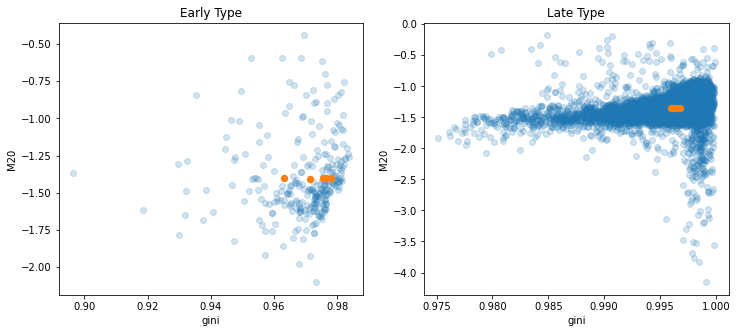

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



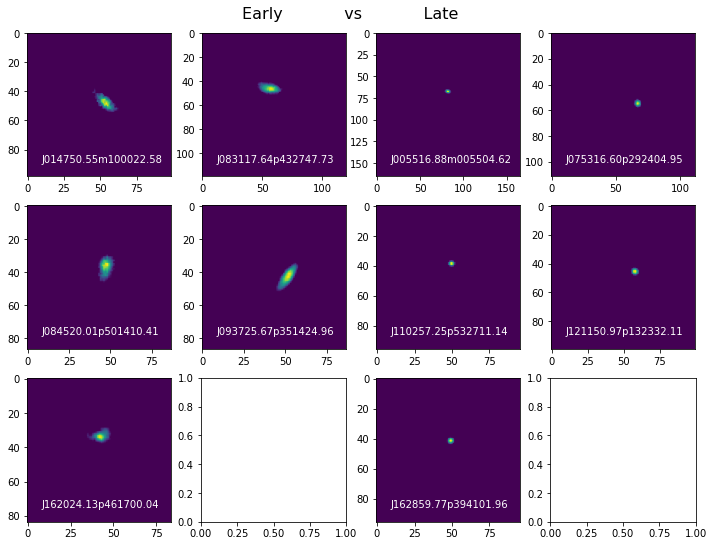

In [51]:
from astrobf import analysis
from astrobf.analysis import binary_clustering

best_parameters, values = axc.get_best_parameters()
best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, cat)

eval_metrics, clustering = Full_exp.do_ML(best_results, labeler, cat,
                                         fields=['gini', 'm20'], 
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

# Get centroids (typicals)
clu1 = best_results[clustering.labels_.astype(bool)]
clu2 = best_results[~clustering.labels_.astype(bool)]

tmo_params = best_parameters
t_ind_E = analysis.utils.get_typical_ind(clu1, n_samples=5)
t_ind_L = analysis.utils.get_typical_ind(clu2, n_samples=5)

typicals = []

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
for ax, group in zip(axs, [clu1, clu2]):
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    
    typicals.append([gal for gal in all_gals if gal['img_name'] in group['id'][t_ind]])

axs[0].set_title("Early Type")
axs[1].set_title("Late Type")

plt.show()

typical_E, typical_L = typicals
binary_clustering.plot_group_comparison(typical_E, typical_L, best_parameters, 
                      suptitle="Early            vs            Late")

## Typical sampes in incremental points 

### Get the 'incremental' points

AttributeError: 'list' object has no attribute 'xaxis'

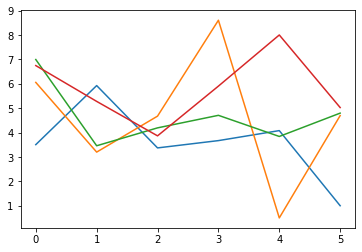

In [72]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

for field in param_arr.dtype.names:
    plt.plot(param_arr[field], label=field)

plt.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
plt.legend()
plt.xlabel("metric")
plt.ylabel("value")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [87]:
typical_E_result = analysis.utils.get_matched_result(best_results, [gal['img_name'] for gal in typical_E])
typical_L_result = analysis.utils.get_matched_result(best_results, [gal['img_name'] for gal in typical_L])

for i, best_params in enumerate(incr_params):
    try:
        binary_clustering.plot_group_comparison(typical_L, typical_E, best_params,
                              fn=f'typical_{i}.png',
                              suptitle=f"scroe: {scores[i_incr[i]]:.4f}")


        this_results = custom_morph.step_simple_morph(all_gals, best_params)
        Full_exp.add_ttype(this_results, cat)

        eval_metrics, clustering = Full_exp.do_ML(this_results, labeler, cat,
                                         fields=['gini', 'm20'], 
                                         return_cluster=True,
                                         cluster_method="ward")

        # Get centroid
        clu0_this = this_results[clustering.labels_==0]
        clu1_this = this_results[clustering.labels_==1]
        clu2_this = this_results[clustering.labels_==2]
        clu3_this = this_results[clustering.labels_==3]

        typical_E_this_result = analysis.utils.get_matched_result(this_results, 
                                                   [gal['img_name'] for gal in typical_E])
        typical_L_this_result = analysis.utils.get_matched_result(this_results, 
                                                   [gal['img_name'] for gal in typical_L])

        binary_clustering.plot_group_evals_w_centers((clu1,clu2), 
                               (typical_E_result, typical_L_result),
                               (clu1_this, clu2_this), 
                               (typical_E_this_result, typical_L_this_result),
                               fn=f"G_M{i}.png")

        binary_clustering.plot_classification_vs_answer(this_results, (clu1, clu2), labeler,
                                        fn=f"current_in_best_color{i}.png")
    except:
        continue

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


## Train two sets of parameters for early / late samples.